In [1]:
#Import functions and libraries from scripts
from GP_funcs import *
from file_opening import *
from SCB_conversion import SCB_CONVERSION

import string

#for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# import matplotlib.patheffects as pe
# for exporting things as mat for matlab
import scipy.io

# For linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# For kernel covariance matrix
import seaborn as sns

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, DotProduct, RationalQuadratic, Matern
import numpy as np
import math

In [2]:
'''User set values for code blocks to run '''
p = 100 #number of points wanted for GP's
colr_sc = ['#1E77B4','#FCAF38',"#BFD061"] #Color scheme
USGS_site_id = ['05325000','05325300','05330000']
markers = ['s', 'o','^', 'D']
labels = list(string.ascii_uppercase)
alpha_site_id = labels[0:len(USGS_site_id)]

plt.rcParams.update({'font.size': 12})

# create_USGS_dfs('sensor', USGS_site_id) 

# Load USGS data

In [3]:
#Load USGS data
# numbers for easy enumeration
site_numbs = np.arange(len(USGS_site_id))
# updates ADVM and grab_samples readings to included calculated SAC and SSC already and calucated dq/dt for samples
ADVM_readings = create_USGS_dfs('sensor', USGS_site_id) #Sensor readings for all sites
Grab_samples = create_USGS_dfs('samples', USGS_site_id) #Grab samples and flow for all sites
Qall_time = create_USGS_dfs('Qall', USGS_site_id) #Discharge for total time range of sensor deployment per site


dfc = pd.read_csv(r'USGS_data/USGS_site_consts.csv') # Read in constants for all sites
dfc['Site_ID'] = dfc['Site_ID'].map(toName) #Converts Site_ID to string type

data_dictionary = {} # empty dictionary to put dataframes into, keys are site id
for i, id in enumerate(USGS_site_id):
    #Selects constants for each USGS site
    Consts = dfc.loc[dfc['Site_ID'] ==  id].iloc[0, 1:]

    data_dictionary[alpha_site_id[i]] = { 'USGS_id' : id,
                            'ADVM' : ADVM_readings[id],
                            'Samples' : Grab_samples[id],
                            'Flow' : Qall_time[id],
                            'Consts' : Consts # This is a pandas series
                        }

# Linear Fits

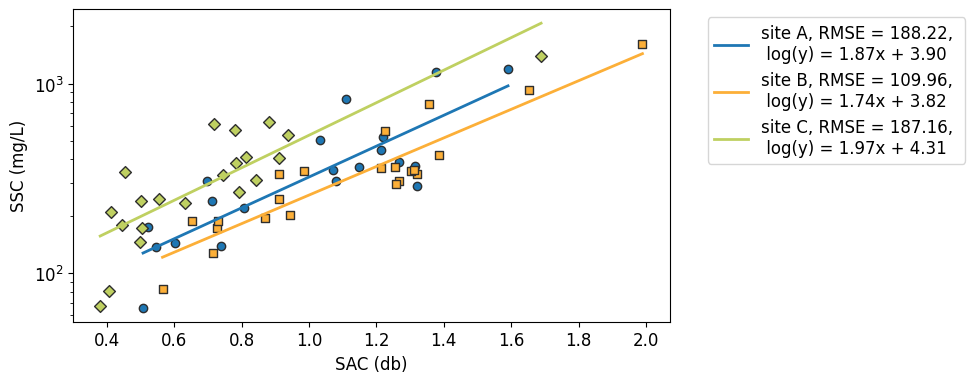

In [65]:
plt.figure(figsize=(10, 4))

for i, id in enumerate(alpha_site_id):
    colr = colr_sc[i]
    mod = data_dictionary[id]['Samples']
    
    # Scatter plot
    x = np.array(mod['SAC']).reshape(-1, 1)
    y = np.array(mod['SSC']).reshape(-1, 1)
    plt.scatter(x, y, color=colr, marker=markers[i], edgecolors='#2E2E2E', zorder=1)
    
    # Use log of y for linear regression
    log_y = np.log(y)
    
    # Linear regression
    model = LinearRegression()
    model.fit(x, log_y)
    log_y_pred = model.predict(x)
    
    # Sort the data for plotting
    sorted_indices = np.argsort(x.ravel())
    x_sorted = x[sorted_indices]
    log_y_pred_sorted = log_y_pred[sorted_indices]
    
    # Calculate the slope and intercept
    slope = model.coef_[0, 0]
    intercept = model.intercept_[0]
    
    # Calculate RMSE using log values
    log_rmse = np.sqrt(mean_squared_error(log_y, log_y_pred))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(np.exp(log_y), np.exp(log_y_pred)))
    
    # Plot the fitted line in the original scale
    plt.plot(x_sorted, np.exp(log_y_pred_sorted), linewidth=2, color=colr, 
             label=f'site {id}, RMSE = {rmse:.2f}, \n log(y) = {slope:.2f}x + {intercept:.2f}')

plt.yscale('log')
plt.xlabel('SAC (db)')
plt.ylabel('SSC (mg/L)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.savefig('figures/linear_fit.png' , dpi=500) 

plt.show()



# Run GP baseline for each site

In [6]:
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=UserWarning, message="One or more of the test scores are non-finite")

def extract_kernel_hyperparams(kernel):
    params = {}
    all_params = kernel.get_params()

    for name, val in all_params.items():
        # Only keep float/numeric hyperparameters (not subkernels)
        if isinstance(val, (float, int, np.float64, np.int64)):
            params[name] = val

    return params

def GP(
    SAC_m, SSC_m, p,
    hyperparams=-999,
    global_min_X=None, global_max_X=None,
    global_min_Y=None, global_max_Y=None,
    SAC_test=None, SSC_test=None,
):
    # Use global min/max if provided
    if global_min_X is not None and global_max_X is not None:
        min_SAC = global_min_X
        max_SAC = global_max_X
    else:
        min_SAC = SAC_m.min()
        max_SAC = SAC_m.max()

    x_range = max_SAC - min_SAC
    if x_range < 1e-8:
        raise ValueError("Input x has too small a range to normalize reliably.")
    X = ((SAC_m - min_SAC) / x_range).reshape(-1, 1)

    if global_min_Y is not None and global_max_Y is not None:
        min_SSC = global_min_Y
        max_SSC = global_max_Y
    else:
        min_SSC = SSC_m.min()
        max_SSC = SSC_m.max()

    y_range = max_SSC - min_SSC
    if y_range < 1e-8:
        raise ValueError("Target y has too small a range to normalize reliably.")
    y = ((SSC_m - min_SSC) / y_range).reshape(-1, 1)


    # Prepare test set if given
    if SAC_test is not None and SSC_test is not None:
        X_test = ((SAC_test - min_SAC) / x_range).reshape(-1, 1)
        y_test = ((SSC_test - min_SSC) / y_range).reshape(-1, 1)
    else:
        X_test, y_test = None, None

    best_rmse = float('inf')
    best_model = None
    best_alpha = None
    best_kernel = None
    best_kernel_params = None
    best_std = None
    best_score = None
    best_log_marg = None


    kernel = ConstantKernel(0.3, (0.05, 0.8)) * RBF(length_scale=0.5, length_scale_bounds=(0.3, 2))
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=False)
    alphas = np.logspace(-2, -1, 10)
    search = GridSearchCV(gp, {'alpha': alphas}, cv=min(5, len(X)))
    search.fit(X, y.ravel())

    best_model = search.best_estimator_
    best_alpha = search.best_params_['alpha']
    best_kernel = best_model.kernel_
    best_score = best_model.score(X, y.ravel())
    best_log_marg = best_model.log_marginal_likelihood()

    # Predict across domain and 10% farther than upper bound
    SAC_pred = np.linspace(0, 1.1, p).reshape(-1, 1)
    Y_pred_scaled, std_scaled = best_model.predict(SAC_pred, return_std=True)
    Y_pred_orig = Y_pred_scaled * y_range + min_SSC
    std_orig = std_scaled * y_range
    SAC_pred_orig = SAC_pred.ravel() * x_range + min_SAC

    return (
        SAC_pred_orig, Y_pred_orig, std_orig,
        best_score, best_log_marg,
        best_model, best_alpha,
        (min_SAC, x_range), (min_SSC, y_range)
    )


In [7]:
from sklearn.model_selection import KFold
import numpy as np
import math
from sklearn.model_selection import StratifiedKFold

model_dictionary = {}
x_key = 'SAC'
y_key = 'SSC'
p = 100  # number of prediction points

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    
for site_id in alpha_site_id:
    site_data = data_dictionary[site_id]['Samples']
    xdata = np.array(site_data[x_key])
    ydata = np.array(site_data[y_key])

    global_min_x = xdata.min()
    global_max_x = xdata.max()
    global_min_y = ydata.min()
    global_max_y = ydata.max()

    if len(xdata) < 3:
        print(f"Skipping site {site_id}, too few samples.")
        continue

    model_dictionary[site_id] = {'folds': {}, 'num_samp': len(xdata)}

   

    n_splits = min(5, len(xdata))
    n_bins = min(10, len(xdata) // n_splits)
    x_binned = np.floor(np.interp(xdata, (xdata.min(), xdata.max()), (0, n_bins))).astype(int)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(xdata, x_binned)):

    # kf = KFold(n_splits=min(5, len(xdata)), shuffle=True, random_state=0)

    # for fold_idx, (train_idx, test_idx) in enumerate(kf.split(xdata)):
        x_train, y_train = xdata[train_idx], ydata[train_idx]
        x_test, y_test = xdata[test_idx], ydata[test_idx]

        try:
            SAC_pred, SSC_pred, std_pred, score, log_marg, model, alpha, x_scale, y_scale = GP(
                x_train, y_train, p,
                SAC_test=x_test, SSC_test=y_test,
                global_min_X=global_min_x, global_max_X=global_max_x,
                global_min_Y=global_min_y, global_max_Y=global_max_y,
            )
        except Exception as e:
            print(f"Fold {fold_idx} failed for site {site_id}: {e}")
            continue

        kernel_params = extract_kernel_hyperparams(model.kernel_)

        x_min, x_range = x_scale
        x_test_scaled = (x_test - x_min) / x_range
        ypred_test_scaled, std_test_scaled = model.predict(x_test_scaled.reshape(-1, 1), return_std=True)

        y_min, y_range = y_scale
        ypred_test = ypred_test_scaled * y_range + y_min
        std_test = std_test_scaled * y_range

        rmse = math.sqrt(np.mean((y_test - ypred_test) ** 2))
        r2 = model.score(x_test_scaled.reshape(-1, 1), (y_test - y_min) / y_range)

        model_dictionary[site_id]['folds'][fold_idx] = {
            'x_train': x_train,
            'y_train': y_train,
            'x_test': x_test,
            'y_test': y_test,
            'n_pred': ypred_test,
            'p_pred': [SAC_pred, SSC_pred, std_pred],
            'scores': {
                'rmse': rmse,
                'r_score': r2,
                'GP_score': score,
                'GP_logmarg': log_marg,
                'alpha': alpha,
                'std': std_test,
            },
            'model': model,
            'hyperparams': kernel_params,
            'x_scaling': x_scale,
            'y_scaling': y_scale,
        }

        print(f"Site {site_id} | Fold {fold_idx} | RMSE: {rmse:.2f} | R^2: {r2:.2f}")

#save median gp_score fold as baseline model


for site_id in model_dictionary:
    fold_data = model_dictionary[site_id].get('folds', {})

    if not fold_data:
        continue  # Skip if no folds available

    # Extract GP scores from all folds
    fold_scores = [(fold_idx, fold['scores']['GP_score']) for fold_idx, fold in fold_data.items()]
    sorted_scores = sorted(fold_scores, key=lambda x: x[1])  # Sort by GP_score

    # Find the median score and corresponding fold
    mid = len(sorted_scores) // 2
    median_fold_idx = sorted_scores[mid][0]  # Use floor of mid (can also average if even count)

    # Save that fold's data as baseline
    model_dictionary[site_id]['baseline'] = {
        'fold_idx': median_fold_idx,
        **fold_data[median_fold_idx]
    }

    print(f"Site {site_id} baseline set to fold {median_fold_idx} with GP_score = {sorted_scores[mid][1]:.3f}")


for site_id in model_dictionary:
    fold_data = model_dictionary[site_id].get('folds', {})

    if not fold_data:
        continue  # Skip if no folds available

    # Extract GP scores from all folds
    fold_scores = [(fold_idx, fold['scores']['GP_score']) for fold_idx, fold in fold_data.items()]
    
    # Sort by GP_score (higher is better)
    sorted_scores = sorted(fold_scores, key=lambda x: x[1], reverse=True)

    # Best-performing fold
    best_fold_idx = sorted_scores[0][0]

    # Save that fold's data as baseline
    model_dictionary[site_id]['baseline'] = {
        'fold_idx': best_fold_idx,
        **fold_data[best_fold_idx]
    }   

sorted_folds = sorted(fold_data.items(), key=lambda x: x[1]['scores']['GP_score'], reverse=True)

# Store as dict keyed by rank with both fold_idx and fold_data
model_dictionary[site_id]['folds_sorted'] = {
    rank: {'fold_idx': fold_idx, 'data': fold_data}
    for rank, (fold_idx, fold_data) in enumerate(sorted_folds)
}




/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:

Site A | Fold 0 | RMSE: 86.58 | R^2: 0.68
Site A | Fold 1 | RMSE: 155.16 | R^2: -4.35


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Use

Site A | Fold 2 | RMSE: 207.02 | R^2: 0.35
Site A | Fold 3 | RMSE: 217.74 | R^2: -2.09


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn

Site A | Fold 4 | RMSE: 593.54 | R^2: -0.62
Site B | Fold 0 | RMSE: 548.61 | R^2: -0.01


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

Site B | Fold 1 | RMSE: 82.40 | R^2: 0.90
Site B | Fold 2 | RMSE: 172.22 | R^2: 0.54


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

Site B | Fold 3 | RMSE: 106.71 | R^2: -2.32
Site B | Fold 4 | RMSE: 87.57 | R^2: -0.71


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

Site C | Fold 0 | RMSE: 547.45 | R^2: -0.61
Site C | Fold 1 | RMSE: 90.67 | R^2: 0.57


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

Site C | Fold 2 | RMSE: 132.29 | R^2: 0.54
Site C | Fold 3 | RMSE: 83.87 | R^2: 0.77
Site C | Fold 4 | RMSE: 105.20 | R^2: -0.01
Site A baseline set to fold 2 with GP_score = 0.526
Site B baseline set to fold 4 with GP_score = 0.907
Site C baseline set to fold 1 with GP_score = 0.760


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.war

Site  Fold  RMSE  GP_score  GP_logmarg  Alpha                             Kernel
   A     0  87.0  0.489875   -3.296899   0.10 0.467**2 * RBF(length_scale=0.928)
   A     1 155.0  0.551735   -3.080004   0.10 0.507**2 * RBF(length_scale=0.914)
   A     2 207.0  0.526404   -2.741278   0.10 0.459**2 * RBF(length_scale=0.846)
   A     3 218.0  0.576461   -2.721968   0.10 0.535**2 * RBF(length_scale=0.876)
   A     4 594.0  0.412414    0.229249   0.10 0.224**2 * RBF(length_scale=0.533)
   B     0 549.0  0.325178    2.855856   0.08  0.224**2 * RBF(length_scale=0.78)
   B     1  82.0  0.900532   10.170909   0.01 0.679**2 * RBF(length_scale=0.554)
   B     2 172.0  0.953124   12.962125   0.01  0.62**2 * RBF(length_scale=0.445)
   B     3 107.0  0.911343   11.519022   0.01 0.757**2 * RBF(length_scale=0.647)
   B     4  88.0  0.906875   11.248695   0.01 0.729**2 * RBF(length_scale=0.607)
   C     0 547.0  0.452035    2.825098   0.08 0.224**2 * RBF(length_scale=0.437)
   C     1  91.0  0.759928  

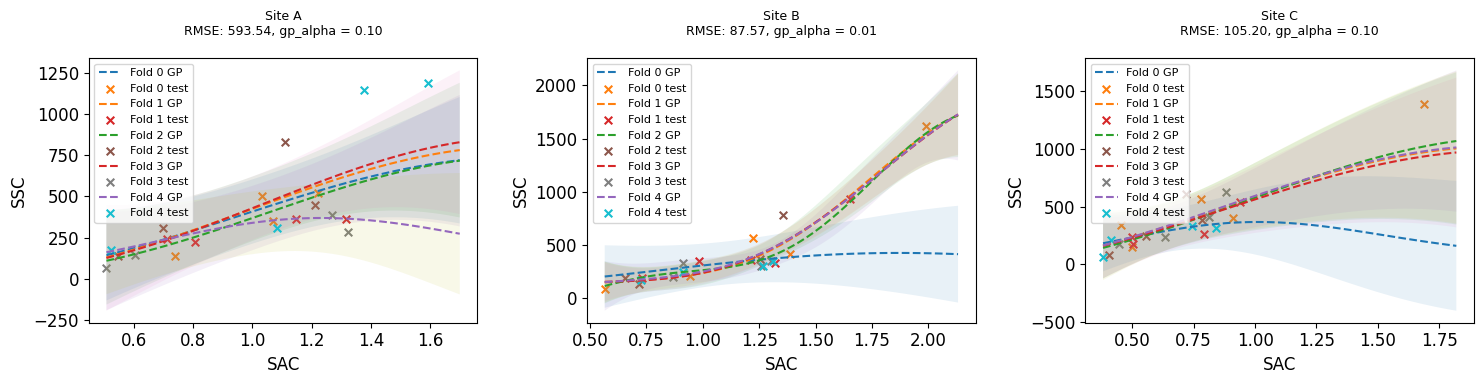

In [ ]:
x_key = 'SAC'
y_key = 'SSC'
from collections import defaultdict

site_ids = list(model_dictionary.keys())
n_sites = len(site_ids)
n_cols = 3
n_rows = math.ceil(n_sites / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=False)
axes = axes.flatten()

# Collect metrics into a list of dicts
summary_rows = []

for i, site_id in enumerate(site_ids):
    ax = axes[i]
    model = model_dictionary[site_id]

    # xdata = model['x']
    # ydata = model['y']
    # ypred = model['n_pred']
    # SAC_pred_all, SSC_pred_all, std_all = model['p_pred']
    # rmse = model['scores']['rmse']
    # gp_alpha = model['scores']['alpha']

    # # Sort for smooth plotting
    # sorted_indices = np.argsort(xdata)
    # x_sorted = xdata[sorted_indices]
    # y_sorted = ypred[sorted_indices]
    # std_sorted = std_all[sorted_indices] if isinstance(std_all, np.ndarray) else np.array(std_all)[sorted_indices]

    # color = colr_sc[i % len(colr_sc)]
    # marker = markers[i % len(markers)] if 'markers' in globals() else 'o'

    # ax.scatter(xdata, ydata, color=color, marker=marker, edgecolors='#2E2E2E', alpha=0.5, label='Observed')
    # ax.plot(x_sorted, y_sorted, color=color, linewidth=2, label='Full GP fit')
    # ax.fill_between(
    #     SAC_pred_all,
    #     SSC_pred_all - 1.96 * std_all,
    #     SSC_pred_all + 1.96 * std_all,
    #     color=color, alpha=0.15, label='Full 95% CI'
    # )

    # Plot each fold’s test prediction
    folds = model.get("folds", {})
    for fold_id, fold_data in folds.items():
        try:
            kernel_str = str(fold_data['model'].kernel_)
        except Exception as e:
            kernel_str = f"Kernel: Unknown ({e})"   
            
        test_x = fold_data['x_test']
        test_y = fold_data['y_test']
        ypred = fold_data['n_pred']
        SAC_pred_all, SSC_pred_all, std_pred_all = fold_data['p_pred']
        std_pred = fold_data['scores']['std']
        gp_alpha = fold_data['scores']['alpha']
        rmse = fold_data['scores']['rmse']
        summary_rows.append({
            "Site": site_id,
            "Fold": fold_id,
            "RMSE": round(rmse, 0),
            "GP_score": fold_data['scores']['GP_score'],
            "GP_logmarg": fold_data['scores']['GP_logmarg'],
            "Alpha": round(gp_alpha, 2),
            "Kernel": kernel_str
        })

       

        sorted_idx = np.argsort(test_x)
        test_x_sorted = test_x[sorted_idx]
        ypred_sorted = ypred[sorted_idx]
        std_sorted = std_pred[sorted_idx]

        ax.plot(SAC_pred_all, SSC_pred_all, linestyle='--', linewidth=1.5, label=f'Fold {fold_id} GP')
        ax.fill_between(
            SAC_pred_all,
            SSC_pred_all - 1.96 * std_pred_all,
            SSC_pred_all + 1.96 * std_pred_all,
            alpha=0.1
        )
        ax.scatter(test_x, test_y, marker='x', s=30, label=f'Fold {fold_id} test')

  

    ax.set_title(
        f"Site {site_id}\nRMSE: {rmse:.2f}, gp_alpha = {gp_alpha:.2f}\n",
        fontsize=9
    )
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)

    # Remove duplicate labels
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), fontsize=8)

# Turn off unused subplots
for j in range(len(site_ids), len(axes)):
    axes[j].axis('off')

# Convert to DataFrame and print
summary_df = pd.DataFrame(summary_rows)
print(summary_df.to_string(index=False))

plt.tight_layout()
plt.show()


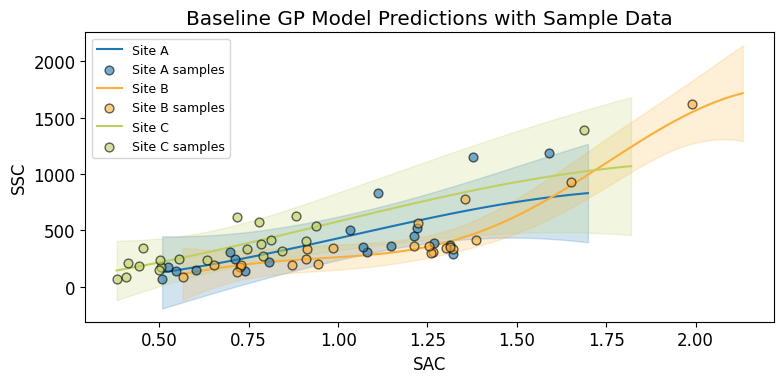


Baseline Model Summary:
Site   RMSE  GP_score  GP_logmarg  Alpha                             Kernel
   A 217.74     0.576        -2.7  0.100 0.535**2 * RBF(length_scale=0.876)
   B 172.22     0.953        13.0  0.010  0.62**2 * RBF(length_scale=0.445)
   C 132.29     0.808         1.0  0.077 0.594**2 * RBF(length_scale=0.928)


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

x_key = 'SAC'
y_key = 'SSC'

fig, ax = plt.subplots(figsize=(8, 4))

baseline_rows = []

for i, site_id in enumerate(model_dictionary.keys()):
    model = model_dictionary[site_id]
    baseline_info = model.get('baseline')
    site_data = data_dictionary[site_id]['Samples']
    xdata = np.array(site_data[x_key])
    ydata = np.array(site_data[y_key])

    if baseline_info is None:
        print(f"No baseline model for site {site_id}")
        continue

    SAC_pred_all, SSC_pred_all, std_pred_all = baseline_info['p_pred']
    rmse = baseline_info['scores']['rmse']
    gp_score = baseline_info['scores']['GP_score']
    gp_logmarg = baseline_info['scores']['GP_logmarg']
    gp_alpha = baseline_info['scores']['alpha']
    kernel_str = str(baseline_info['model'].kernel_)

    # Plot model prediction and CI
    ax.plot(SAC_pred_all, SSC_pred_all, color=colr_sc[i], label=f"Site {site_id}", zorder=1)
    ax.fill_between(
        SAC_pred_all,
        SSC_pred_all - 1.96 * std_pred_all,
        SSC_pred_all + 1.96 * std_pred_all,
        color=colr_sc[i],
        alpha=0.2,
        zorder=0,
    )

    # Plot observed samples
    ax.scatter(xdata, ydata, color=colr_sc[i], marker='o', edgecolor='k', s=40, alpha=0.6, label=f"Site {site_id} samples", zorder=2)

    # Save summary info
    baseline_rows.append({
        "Site": site_id,
        "RMSE": round(rmse, 2),
        "GP_score": round(gp_score, 3),
        "GP_logmarg": round(gp_logmarg, 1),
        "Alpha": round(gp_alpha, 3),
        "Kernel": kernel_str
    })

# Plot formatting
ax.set_title("Baseline GP Model Predictions with Sample Data")
ax.set_xlabel(x_key)
ax.set_ylabel(y_key)

# Deduplicate legend
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), fontsize=9)

plt.tight_layout()
plt.show()

# Print summary table
summary_df = pd.DataFrame(baseline_rows)
print("\nBaseline Model Summary:")
print(summary_df.to_string(index=False))


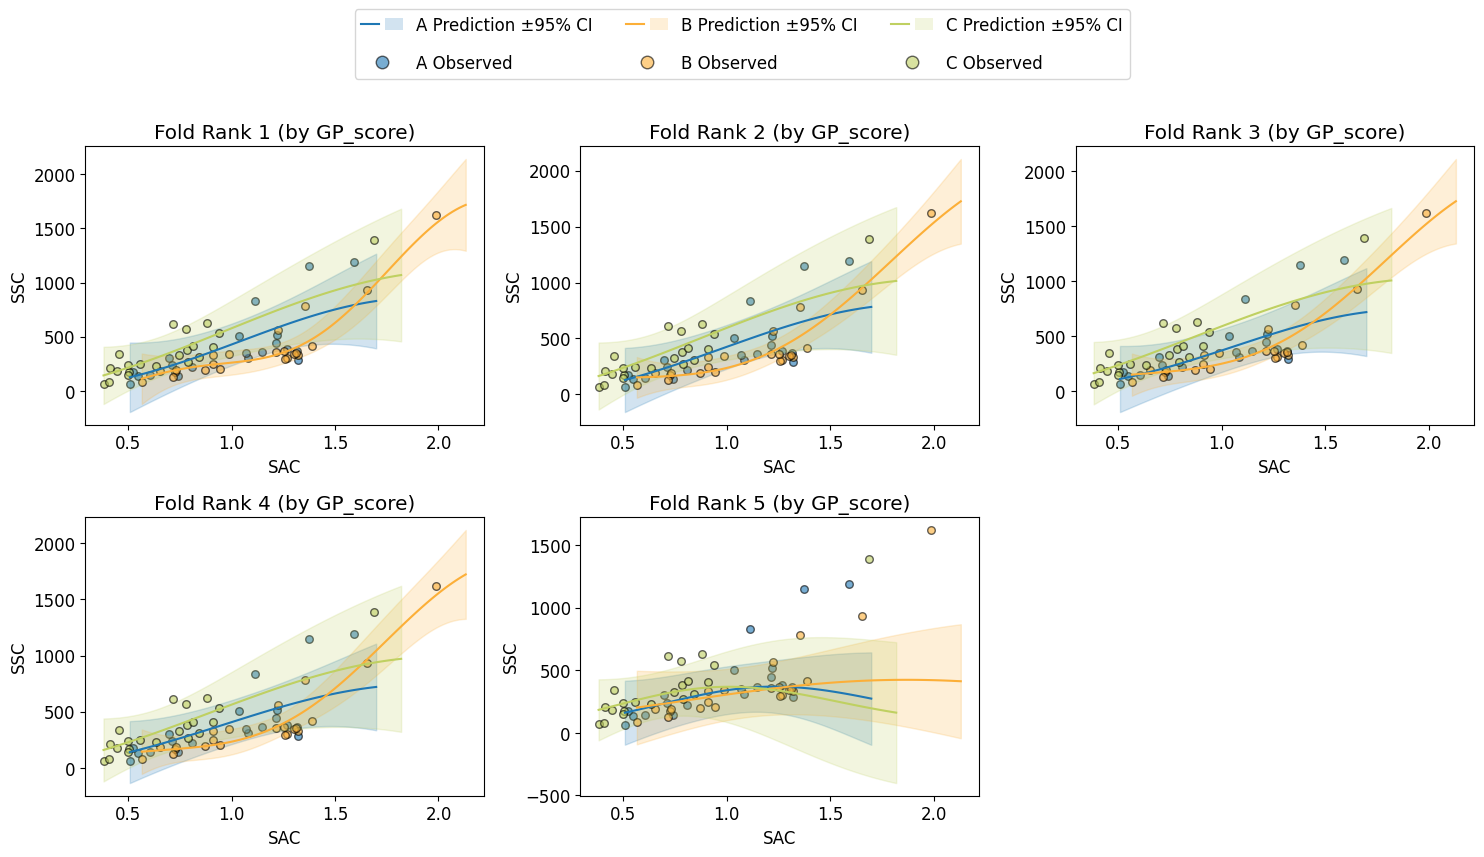

In [ ]:
x_key = 'SAC'
y_key = 'SSC'

# Get number of folds per site
num_folds = max(len(model['folds']) for model in model_dictionary.values())

# Setup subplots
ncols = 3
nrows = int(np.ceil(num_folds / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)

# For shared legend
legend_handles = []
legend_labels = []
added_sites = set()

for fold_rank in range(num_folds):
    ax = axes[fold_rank // ncols][fold_rank % ncols]
    ax.set_title(f"Fold Rank {fold_rank + 1} (by GP_score)")

    for site_idx, (site_id, model) in enumerate(model_dictionary.items()):
        site_data = data_dictionary[site_id]['Samples']
        xdata = np.array(site_data[x_key])
        ydata = np.array(site_data[y_key])

        folds = model.get('folds', {})
        if not folds:
            continue

        # Sort folds by GP_score descending
        sorted_folds = sorted(folds.items(), key=lambda x: x[1]['scores']['GP_score'], reverse=True)
        if fold_rank >= len(sorted_folds):
            continue

        fold_idx, fold_info = sorted_folds[fold_rank]
        SAC_pred_all, SSC_pred_all, std_pred_all = fold_info['p_pred']

        color = colr_sc[site_idx % len(colr_sc)]  # Cycle colors

        # Plot GP prediction
        ax.plot(SAC_pred_all, SSC_pred_all, color=color)

        # Plot confidence interval
        ax.fill_between(
            SAC_pred_all,
            SSC_pred_all - 1.96 * std_pred_all,
            SSC_pred_all + 1.96 * std_pred_all,
            color=color,
            alpha=0.2
        )

        # Plot observed data
        ax.scatter(xdata, ydata, color=color, edgecolor='k', s=30, alpha=0.6)

        # Add custom legend entries once per site
        if site_id not in added_sites:
            # Combined prediction line + shaded area
            pred_line = Line2D([], [], color=color)
            ci_patch = Patch(facecolor=color, alpha=0.2)
            legend_handles.append((pred_line, ci_patch))
            legend_labels.append(f"{site_id} Prediction ±95% CI")

            # Observed marker
            obs_marker = Line2D([], [], color=color, marker='o', linestyle='None',
                                markeredgecolor='k', alpha=0.6)
            legend_handles.append(obs_marker)
            legend_labels.append(f"{site_id} Observed")

            added_sites.add(site_id)

    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)

# Remove empty subplots if any
total_plots = nrows * ncols
for idx in range(num_folds, total_plots):
    fig.delaxes(axes[idx // ncols][idx % ncols])

# Shared legend at top
fig.legend(
    handles=legend_handles,
    labels=legend_labels,
    handler_map={tuple: HandlerTuple(ndivide=None)},
    loc='upper center',
    ncol=3,  # Adjust based on number of sites
    fontsize=12,
    handlelength=2.5,
    markerscale=1.5,
    labelspacing=1.2,
    bbox_to_anchor=(0.5, 1.08)
)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at the top for legend
plt.show()


In [70]:
# Initialize the new dictionary
cross_prediction_dictionary = {site_id: {} for site_id in alpha_site_id}

# Loop through each combination of test and model sites
for model_id in alpha_site_id:
    for site_id in alpha_site_id:
        # Get the model from the model_dictionary
        GP_model = model_dictionary[model_id]['baseline']['model']

        # Get the test site data
        test_data = data_dictionary[site_id]["Samples"]
        # x_test = test_data['Samples']['SAC'].to_numpy()
        # y_test = test_data['Samples']['SSC'].to_numpy()
        x_test = np.array(test_data[x_key])
        y_test = np.array(test_data[y_key])

        x_range = max(x_test) - min(x_test)
        y_range = max(y_test) - min(y_test)

        x_test_scaled = (x_test - min(x_test)) / x_range
    

        # Use the model to predict SSC for the test data
        y_pred_scaled, std_pred_scaled = GP_model.predict(x_test_scaled.reshape(-1, 1), return_std=True)

        y_pred = y_pred_scaled * y_range + min(y_test)
        std_pred = std_pred_scaled * y_range
        # Calculate scores
        MSE = np.square(np.subtract(y_test, y_pred)).mean()
        rmse = math.sqrt(MSE)
        r_score = GP_model.score(y_pred.reshape(-1, 1), y_test.reshape(-1, 1))

        hp =  extract_kernel_hyperparams(GP_model.kernel_)

        # Store the results in the new dictionary
        cross_prediction_dictionary[site_id][model_id] = {
            'hyperparams': hp,
            'x': x_test,
            'y': y_test,
            'n_pred': ypred,
            'scores': {
                'r_score': r_score, 
                'rmse' : rmse, 
                'std': std_pred
            },
            'model': GP_model
                                           
        }

In [69]:
print("RMSE for all sites with different models used to predict on it:")

for site_id in alpha_site_id:
    print(f"\nTest Site: {site_id}")
    # base_r, base_rmse = model_dictionary[site_id]['scores'][2:4]
    # print(f"  Baseline from Site {site_id}: RMSE = {base_rmse:.2f}; R = {base_r:.2f}")

    for i, model_id in enumerate(alpha_site_id):
        rmse = cross_prediction_dictionary[site_id][model_id]['scores']['rmse']
        r = cross_prediction_dictionary[site_id][model_id]['scores']['r_score']
        print(f"  Model from Site {model_id}: RMSE = {rmse:.0f}")


RMSE for all sites with different models used to predict on it:

Test Site: A
  Model from Site A: RMSE = 209
  Model from Site B: RMSE = 191
  Model from Site C: RMSE = 222

Test Site: B
  Model from Site A: RMSE = 223
  Model from Site B: RMSE = 100
  Model from Site C: RMSE = 261

Test Site: C
  Model from Site A: RMSE = 148
  Model from Site B: RMSE = 182
  Model from Site C: RMSE = 130


## Compute correlation matricies

In [11]:
def const_rbf_kernel(x, y, length_scale, const):
    rbf = math.exp(- math.dist([x],[y]) / (2*length_scale**2) )
    return const * rbf

def cov_to_cor(cov):
    d = np.sqrt(np.diag(cov))
    return cov / np.outer(d, d)

correlation_matrices = {}
n_range = [10, 25, 50]

for id in alpha_site_id:
    correlation_matrices[id] = {}
    
    if 'baseline' not in model_dictionary[id]:
        print(f"Skipping site {id}, no baseline model found.")
        continue

    mod = model_dictionary[id]['baseline']
    x = np.array(mod['x_train'])
    y = np.array(mod['y_train'])
    # pred_x = np.array(mod['p_pred'][0])
    # pred_y = np.array(mod['p_pred'][1])

    # Hyperparameters 
    hp = mod['hyperparams']
    const = hp.get('k1__constant_value', None)
    l = hp.get('k2__length_scale', None)

    if l is None or const is None:
        raise ValueError(f"Missing hyperparameters in site {id}")

    # Sort input data
    ord = np.argsort(x)
    x_sort = x[ord]
    y_sort = y[ord]

    x_min = np.min(x_sort)
    x_max = np.max(x_sort)
    x_sort_scaled = (x_sort - x_min) / (x_max - x_min)

    # --- Variable number of prediction points using this site's kernel ---
    correlation_matrices[id]['n'] = {}
    for n in n_range:
        nx_trend_scaled = np.linspace(0, 1, n)
        kern = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                kern[i, j] = const_rbf_kernel(nx_trend_scaled[i], nx_trend_scaled[j], l, const)
        cor_mat = cov_to_cor(kern)

        correlation_matrices[id]['n'][n] = {
            'hyperparams': {
                'length_scale': l,
                'constant_value': const,
            },
            'cor_matrix': cor_mat,
            'range': nx_trend_scaled * (x_max - x_min) + x_min,
            'range_scaled': nx_trend_scaled,
        }

    # --- Evaluate all other sites' kernels on this site's inputs ---
    correlation_matrices[id]['num_samp'] = {}
    for model_id in alpha_site_id:
        if 'baseline' not in model_dictionary[model_id]:
            print(f"Skipping model from {model_id}, no baseline.")
            continue

        hp_mod = model_dictionary[model_id]['baseline']['hyperparams']
        const_mod = hp_mod.get('k1__constant_value', None)
        l_mod = hp_mod.get('k2__length_scale', None)

        if const_mod is None or l_mod is None:
            continue

        samp_n = len(x_sort_scaled)
        kern = np.zeros((samp_n, samp_n))
        for i in range(samp_n):
            for j in range(samp_n):
                kern[i, j] = const_rbf_kernel(x_sort_scaled[i], x_sort_scaled[j], l_mod, const_mod)
        cor_mat = cov_to_cor(kern)

        correlation_matrices[id]['num_samp'][model_id] = {
            'hyperparams': {
                'length_scale': l_mod,
                'constant_value': const_mod,
            },
            'cor_matrix': cor_mat,
            'range': x_sort,
            'range_scaled': x_sort_scaled,
            'n': samp_n,
        }

        print(f"→ Site {id} using model {model_id}: corr shape {cor_mat.shape}")



→ Site A using model A: corr shape (16, 16)
→ Site A using model B: corr shape (16, 16)
→ Site A using model C: corr shape (16, 16)
→ Site B using model A: corr shape (18, 18)
→ Site B using model B: corr shape (18, 18)
→ Site B using model C: corr shape (18, 18)
→ Site C using model A: corr shape (17, 17)
→ Site C using model B: corr shape (17, 17)
→ Site C using model C: corr shape (17, 17)


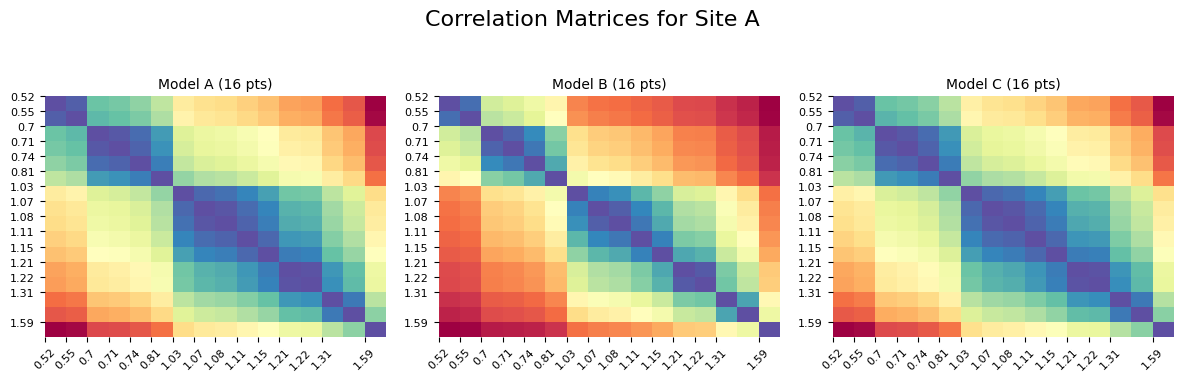

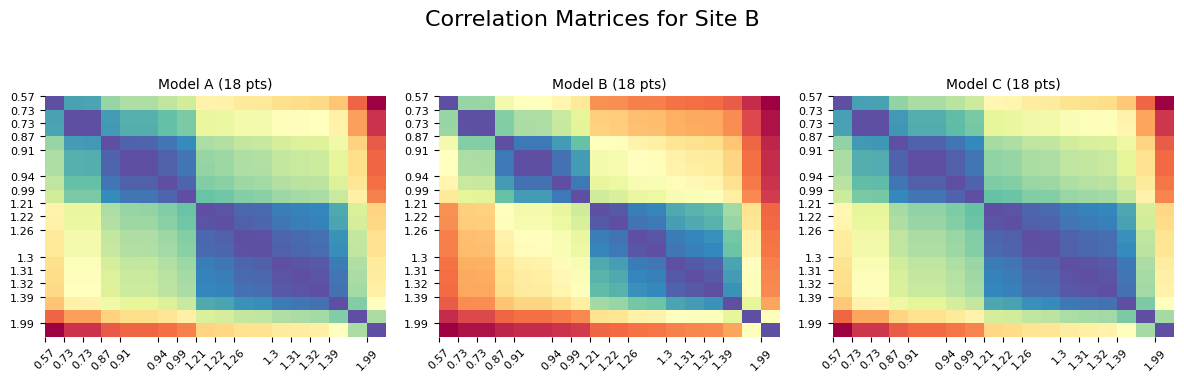

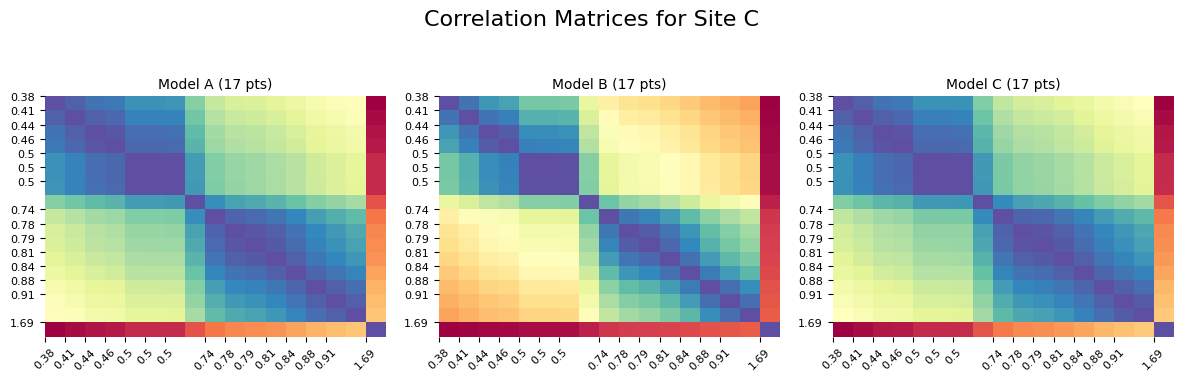

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

for id, models in correlation_matrices.items():
    num_models = len(models['num_samp'])
    num_plots = num_models
    nrows, ncols = 1, num_models  # Adjusted to fit all models in one row

    fig, axes = plt.subplots(nrows, ncols, figsize=(4* n_cols, 4* n_rows))
    axes = axes.flatten()

    for index, (model_id, data) in enumerate(models['num_samp'].items()):
        if index >= len(axes):
            break

        cor_mat = data['cor_matrix']
        nx_trend = data['range']
        n_points = len(nx_trend)

        # Decide whether to annotate or use tick labels based on matrix size
        show_ticks = n_points <= 20
        xticks = np.round(np.sort(nx_trend), 2) if show_ticks else False
        yticks = np.round(np.sort(nx_trend), 2) if show_ticks else False
        nx_trend_sorted = np.sort(nx_trend)  # make sure x is sorted

        # Decide how many ticks to show (15 or fewer)
        n_total = len(nx_trend_sorted)
        n_ticks = min(15, n_total)

        # Get tick indices evenly spaced by index
        tick_indices = np.linspace(0, n_total - 1, n_ticks, dtype=int)
        tick_labels = np.round(nx_trend_sorted[tick_indices], 2)

        sns.heatmap(
            cor_mat,
            cbar=False,
            annot=False,  # turn on if n_points is small and needed
            cmap="Spectral",
            fmt='.2f',
            ax=axes[index],
            xticklabels=False,
            yticklabels=False
        )
        axes[index].set_title(f'Model {model_id} ({n_points} pts)', fontsize=10)
        # Set manual ticks and labels
        axes[index].set_xticks(tick_indices)
        axes[index].set_xticklabels(tick_labels, rotation=45, fontsize=8) 


        axes[index].set_yticks(tick_indices)
        axes[index].set_yticklabels(tick_labels, fontsize=8)

    # Hide any unused axes
    for j in range(index + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f'Correlation Matrices for Site {id}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    # Optional: save to file
    # plt.savefig(f'correlation_matrices_site_{id}.png', dpi=150)
    plt.close()


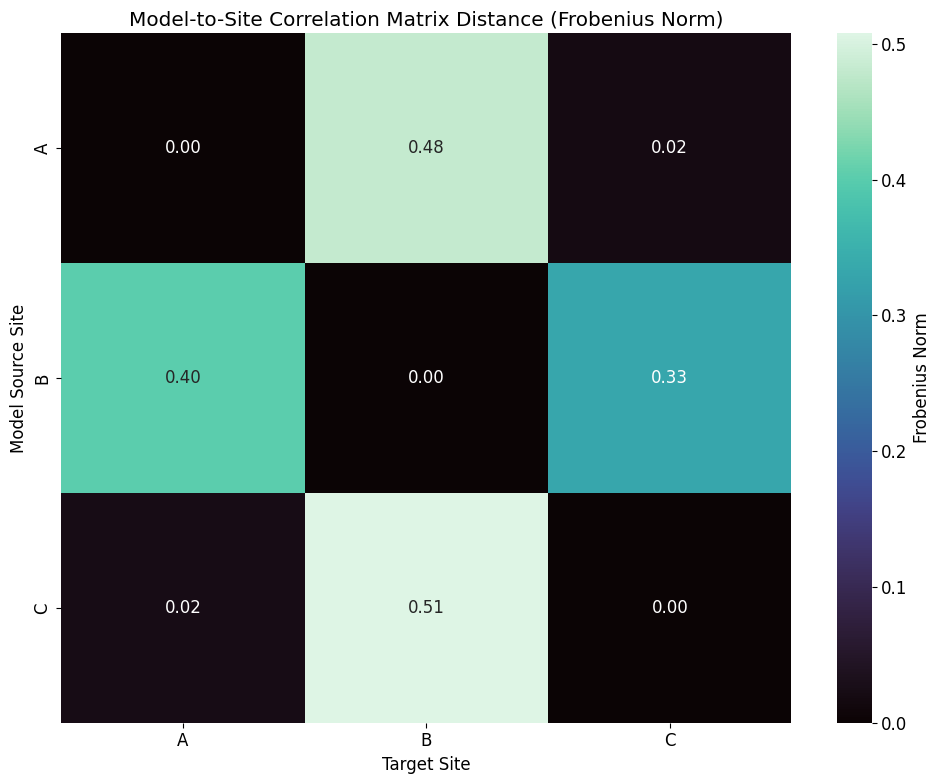

In [58]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

site_ids = list(correlation_matrices.keys())
n_sites = len(site_ids)

# Frobenius distance matrix (models vs sites)
fro_rel_matrix = np.zeros((n_sites, n_sites))

for i, model_site in enumerate(site_ids):
    for j, target_site in enumerate(site_ids):
        try:
            # Model from model_site, applied to target_site
            A = correlation_matrices[target_site]['num_samp'][model_site]['cor_matrix']

            # Reference matrix: model trained & applied on target_site itself
            B = correlation_matrices[target_site]['num_samp'][target_site]['cor_matrix']
            n = B.shape[0]

            # Option 1: normalized by sqrt(n)
            norm_diff = np.linalg.norm(A - B, 'fro') / np.sqrt(n)

            # Option 2: relative to reference matrix norm
            ref_norm = np.linalg.norm(B, 'fro')
            rel_diff = np.linalg.norm(A - B, 'fro') / ref_norm if ref_norm != 0 else np.nan

            fro_rel_matrix[i, j] = rel_diff  # use rel_diff or norm_diff

        except KeyError:
            continue  # Leave as NaN if matrix doesn't exist

plt.figure(figsize=(10, 8))
sns.heatmap(fro_rel_matrix, annot=True, fmt=".2f", cmap="mako", 
            xticklabels=site_ids, yticklabels=site_ids, cbar_kws={'label': 'Frobenius Norm'})

plt.xlabel("Target Site")
plt.ylabel("Model Source Site")
plt.title("Model-to-Site Correlation Matrix Distance (Frobenius Norm)")
plt.tight_layout()
plt.show()



# Matlab OMP calculation

## Save correlation mat for matlab

In [16]:
MATLAB_FILEPATH = "GVR_USGS"
MATLAB_FILEPATH_ALLSAMP = MATLAB_FILEPATH + "/all_samp"
MATLAB_FILEPATH_ALLSAMP_N = MATLAB_FILEPATH_ALLSAMP + "/n_point"   

In [17]:

# do this to get the cor matrix
for id, models in correlation_matrices.items():
    print(f"data set: ")
    
    
    for model_id, data in models['num_samp'].items():
        # print("model_id:" , model_id)
        cor_mat = data['cor_matrix']
        nx_trend = data['range_scaled']
        
        scipy.io.savemat(f'{MATLAB_FILEPATH_ALLSAMP}/corr_samp{id}{model_id}.mat', {'cor_mat': cor_mat})
    scipy.io.savemat(f'{MATLAB_FILEPATH_ALLSAMP}/xdata_scaled_samp{id}.mat', {'xdata': nx_trend})
    
    
    
    # save n samples too
    for n, data in models['n'].items():
        # print("num_points:" , n)
        cor_mat = data['cor_matrix']
        nx_trend = data['range_scaled']
        
        scipy.io.savemat(f'{MATLAB_FILEPATH_ALLSAMP_N}/xdata_scaled_range{id}{n}.mat', {'xdata': nx_trend})
        scipy.io.savemat(f'{MATLAB_FILEPATH_ALLSAMP_N}/corr_range{id}{n}.mat', {'cor_mat': cor_mat})
        


data set: 
data set: 
data set: 


## Read OMP selection from Matlab

In [18]:
""" read sample selection and scores given arbritrary SAC range """
range_selection = {}

for id in alpha_site_id:
    range_selection[id] = {}
    for n in n_range:
        range_selection[id][n] = {}
        mat_dict = range_selection[id][n]
        mat_file = scipy.io.loadmat(f'{MATLAB_FILEPATH_ALLSAMP_N}/range{id}{n}.mat')
        mat_dict['samples'] = mat_file['A'][0]-1 # for matlab to python indexing
        mat_dict['score'] = mat_file['scores'][0]

""" read in sample selection out of grab samples we already have (permutating through each correlation matrix that was used to select samples) """
grabSamp_selection = {}

# selects site with grab samples used
for id in alpha_site_id:
    grabSamp_selection[id] = {}
    # cycle through kernel used
    for model_id in alpha_site_id:
        grabSamp_selection[id][model_id] = {}
        mat_dict = grabSamp_selection[id][model_id] 
        mat_file = scipy.io.loadmat(f'{MATLAB_FILEPATH_ALLSAMP}/samp{id}{model_id}.mat')
        mat_dict['samples'] = mat_file['A'][0]-1 # for matlab to python indexing
        mat_dict['score'] = mat_file['scores'][0]


## Plot Elbow Curve

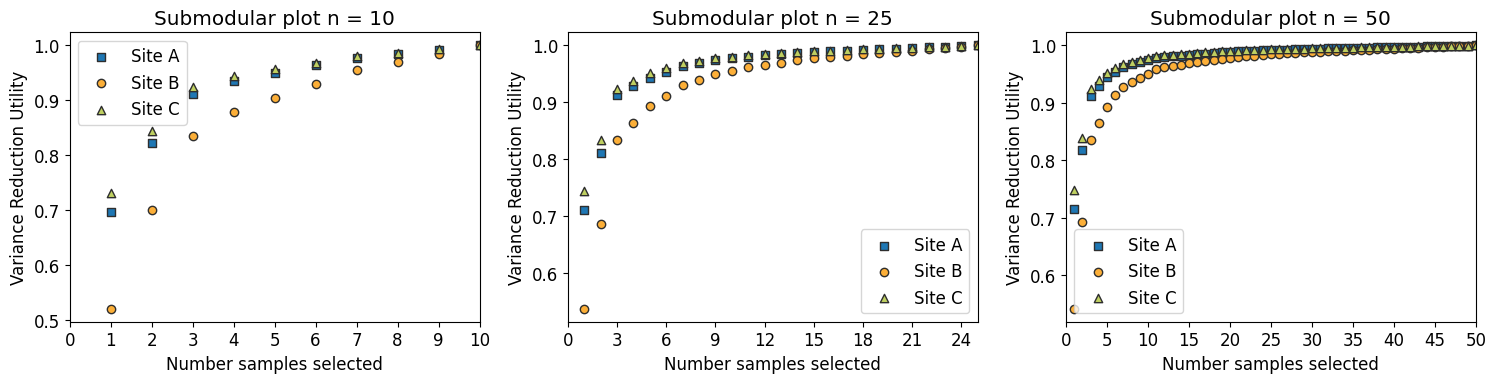

In [19]:
# Plotting the curves with subplots for each item in n_range
n_sites = len(site_ids)
n_cols = 4
n_rows = math.ceil(n_sites / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5* n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, n in enumerate(n_range):
    if idx >= len(axes):
        break  # In case n_range has more than 4 items

    ax = axes[idx]
    for i, id in enumerate(alpha_site_id):
        dict_data = range_selection[id][n]
        samples = dict_data['samples']
        scores = dict_data['score']
        
        # Create a consistent x-axis since the samples is sample number, but we care about number of samples selected
        x_axis = range(1, len(samples) + 1)
        
        # Plot the curve, preserving the relationship between samples and scores
        ax.scatter(x_axis, scores, color=colr_sc[i], marker=markers[i], edgecolors='#2E2E2E', label=f'Site {id}')

    
    ax.set_xlabel('Number samples selected')
    ax.set_ylabel('Variance Reduction Utility')
    ax.set_title(f'Submodular plot n = {n}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_xlim(0, len(samples))

# Hide any unused subplots if n_range has less than 4 items
for i in range(len(n_range), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

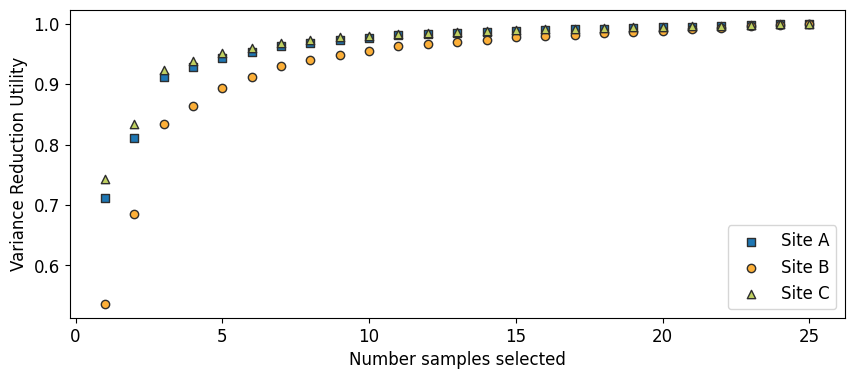

In [20]:
# plot only for n = 25

fig, ax = plt.subplots(figsize=(10, 4))

for i, id in enumerate(alpha_site_id):
    dict_data = range_selection[id][25]
    samples = dict_data['samples']
    scores = dict_data['score']
    
    # Create a consistent x-axis since the samples is sample number, but we care about number of samples selected
    x_axis = range(1, len(samples) + 1)
    
    # Plot the curve, preserving the relationship between samples and scores
    ax.scatter(x_axis, scores, color=colr_sc[i], marker=markers[i], edgecolors='#2E2E2E', label=f'Site {id}')


ax.set_xlabel('Number samples selected')
ax.set_ylabel('Variance Reduction Utility')
ax.legend()
# plt.savefig('figures/submod_n25.png', dpi=500)

## Elbows with actual field samples

A C plotted
B C plotted
C C plotted


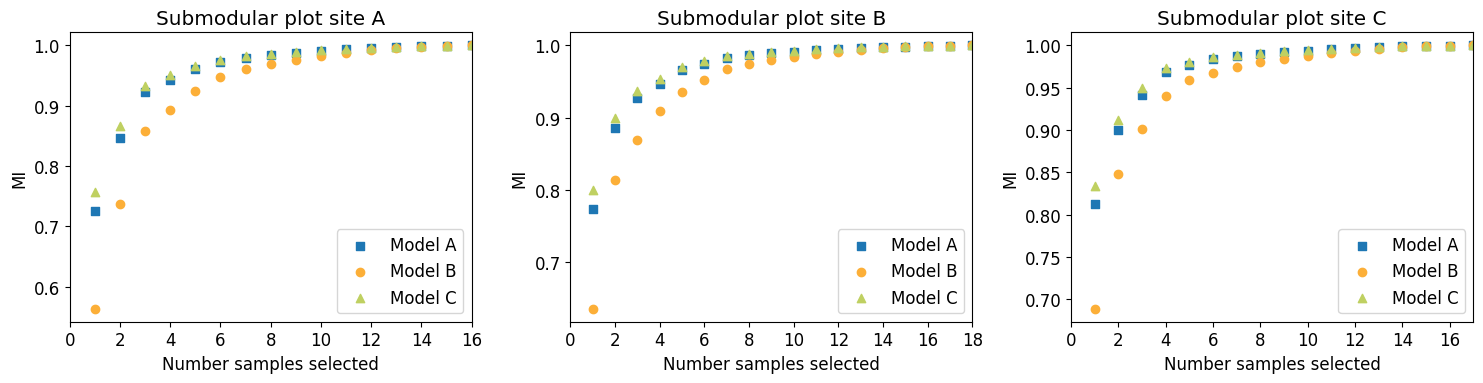

In [21]:
# Plotting the curves with subplots for each item in n_range
n_sites = len(site_ids)
n_cols = 4
n_rows = math.ceil(n_sites / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5* n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, id in enumerate(alpha_site_id):
    if idx >= len(axes):
        break  # In case id_range has more than 9 items

    ax = axes[idx]
    for i, model_id in enumerate(alpha_site_id):
        dict_data = grabSamp_selection[id][model_id]
        samples = dict_data['samples']
        scores = dict_data['score']
        
        # Create a consistent x-axis since the samples is sample number, but we care about number of samples selected
        x_axis = range(1, len(samples) + 1)
        
        # Plot the curve, preserving the relationship between samples and scores
        ax.scatter(x_axis, scores, color=colr_sc[i], marker=markers[i], label=f'Model {model_id}')
    print(id, model_id, 'plotted')

    
    ax.set_xlabel('Number samples selected')
    ax.set_ylabel('MI')
    ax.set_title(f'Submodular plot site {id}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_xlim(0, len(samples))

# Hide any unused subplots if alpha_site_id has less than 3 items
for i in range(len(alpha_site_id), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Error Plots
## Calculating for optimal selection
### Start at 2 samples to train and increase to 80% of available samples

In [22]:
# make array of sample order 
for idx, id in enumerate(alpha_site_id):
    if idx >= len(axes):
        break  # In case id_range has more than 9 items

    ax = axes[idx]
    for model_id in alpha_site_id:
        dict_data = grabSamp_selection[id][model_id]
        samples = dict_data['samples']
        scores = dict_data['score']

        print(samples)

[ 8  2 13 15  4  0 10  5 14  6  9 11  3  1  7 12]
[ 8  2 13  4 15  0 10  5 14  6  9 11  3  1  7 12]
[ 8  2 13 15  4  0 10  5 14  6  9 11  3  1  7 12]
[ 9  2 17  6 14  0 16  4 12  1  7 11 15  5 13  3  8 10]
[10  2 17  6 14 16  0  4  8  1 12  7 15  5 13  3  9 11]
[ 9  2 17  6 14  0 16  4 12  1  7 11 15  5 13  3  8 10]
[ 8  2 16 14  6 11  4  7  0 13 15  5  9 12  3 10  1]
[ 9  2 16 14  6 11  4  7  0 13 15  5  8 12  3 10  1]
[ 8  2 16 14  6 11  4  7  0 13 15  5  9 12  3 10  1]


In [23]:
optimal_dictionary = {}

import warnings
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=UserWarning, message="One or more of the test scores are non-finite")


for i, site_id in enumerate(alpha_site_id):
    # site_data = data_dictionary[site_id]
    # all model data
    baseline_data = model_dictionary[site_id]['baseline']
    # all avaialbe training samples to select from
    all_x = baseline_data['x_train']
    all_y = baseline_data['y_train']
    # What to test models on
    test_x = baseline_data['x_test']
    test_y = baseline_data['y_test']

    globalX = np.concatenate([all_x, test_x])
    globalY = np.concatenate([all_y, test_y])
    global_min_x = globalX.min()
    global_max_x = globalX.max()
    global_min_y = globalY.min()
    global_max_y = globalY.max()
          
    num_train = len(all_x)

    baseline_rmse = baseline_data['scores']['rmse']
    baseline_r2 = baseline_data['scores']['r_score']
    # Hyperparameters 
    hp = baseline_data['hyperparams']
    print(hp)
    baesline_const = hp.get('k1__constant_value', None)
    baseline_l = hp.get('k2__length_scale', None)

    # sort data
    ord = np.argsort(all_x)
    all_x_sort = all_x[ord] 
    all_y_sort = all_y[ord]


    optimal_dictionary[site_id] = { 'baseline_hyperparams': {
                                        'length_scale' : baseline_l,
                                        'constant_value' : baesline_const,
                                    },
                                    'x_sort' : all_x_sort,
                                    'y_sort' : all_y_sort,
                                    'x_test' : test_x,
                                    'y_test' : test_y,
                                    'global_x': globalX,
                                    'global_y': globalY,
                                    'baseline_rmse' : baseline_rmse,
                                    'baseline_r_score' : baseline_r2,
                                    'num_train': num_train + len(test_x),
                                    'sample_limit': num_train,
    }

    for model_id in alpha_site_id:
        opt_select = grabSamp_selection[site_id][model_id]
        opt_indices = opt_select['samples']

        print(f'length of samples: {len(opt_indices)}')
        # initialize optimal_dicitionary 
        optimal_dictionary[site_id][model_id] = {}


        # leave 20% of samples for testing
        for n in np.arange(2,num_train):
            selected_idx = opt_indices[:n]
            opt_x = all_x_sort[selected_idx]
            opt_y = all_y_sort[selected_idx]

            # print(f'length of optx: {len(opt_x)}; n: {n}, length of test: {len(test_x)}')

            # train model using only optimal samples
            # SAC_pred_opt, SSC_pred_opt, std_opt, GP_score_opt, GP_logmarg_opt, GP_model, n_alpha, x_scale, y_scale  = GP(opt_x, opt_y, p) 
            SAC_pred_opt, SSC_pred_opt, std_opt, GP_score_opt, GP_logmarg_opt, GP_model, n_alpha, x_scale, y_scale = GP(
                opt_x, opt_y, p,
                SAC_test=test_x, SSC_test=test_y,
                global_min_X=global_min_x, global_max_X=global_max_x,
                global_min_Y=global_min_y, global_max_Y=global_max_y,
            )
            kernel_params = extract_kernel_hyperparams(GP_model.kernel_)
            x_min, x_range = x_scale
            x_scaled = (test_x - x_min) / x_range
             # important ypred and ydata are sorted same order wrt xdata
            ypred_scaled, std_pred_scaled = GP_model.predict(x_scaled.reshape(-1, 1), return_std=True)  

            y_min, y_range = y_scale
            ypred = ypred_scaled * y_range + y_min
            std_pred = std_pred_scaled * y_range   

            MSE_opt = np.square(np.subtract(test_y,ypred)).mean() 
            rmse_opt = math.sqrt(MSE_opt)

            r_score_opt = GP_model.score(ypred.reshape(-1, 1),test_y.reshape(-1, 1))

            optimal_dictionary[site_id][model_id][n] = {    'hyperparams': kernel_params,
                                                            'x_train' : opt_x,
                                                            'y_train' : opt_y,
                                                            'n_pred' : ypred,
                                                            'p_pred' : [SAC_pred_opt, SSC_pred_opt, std_opt],
                                                            'scores': {
                                                                'GP_score':GP_score_opt, 
                                                                'GP_logmarg':GP_logmarg_opt,
                                                                'r_score': r_score_opt, 
                                                                'rmse' : rmse_opt, 
                                                                'std': std_pred,
                                                            },
                                                            'model' : GP_model,
                                                        }

{'k1__constant_value': 0.2859543424450591, 'k2__length_scale': 0.8758747978304637}
length of samples: 16


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regr

length of samples: 16


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 2.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process

length of samples: 16


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 2.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process

{'k1__constant_value': 0.3838169415388071, 'k2__length_scale': 0.4445323695088585}
length of samples: 18


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  

length of samples: 18


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 2.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regress

length of samples: 18


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__co

{'k1__constant_value': 0.35279644019212697, 'k2__length_scale': 0.9275657803910052}
length of samples: 17


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 2.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regress

length of samples: 17


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3

length of samples: 17


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  

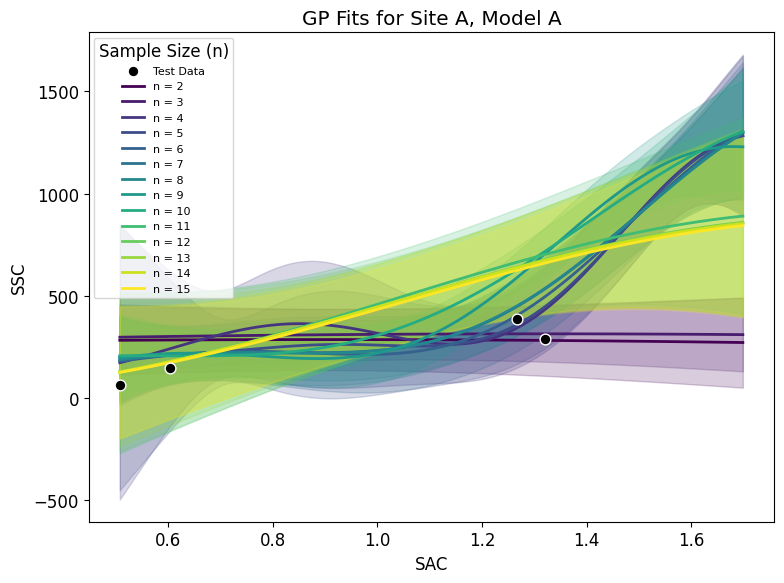

In [25]:
import matplotlib.pyplot as plt

site_id = 'A'
model_id = 'A'

fig, ax = plt.subplots(figsize=(8, 6))

# Get the global test data from the site's baseline model
baseline = model_dictionary[site_id]['baseline']
test_x = baseline['x_test']
test_y = baseline['y_test']

# Plot test data
ax.scatter(test_x, test_y, color='black', edgecolors='white', s=60, label='Test Data', zorder=5)


# Colormap for distinction
colors = plt.cm.viridis(np.linspace(0, 1, len(optimal_dictionary[site_id][model_id])))

for idx, n in enumerate(sorted(optimal_dictionary[site_id][model_id].keys())):
    fold = optimal_dictionary[site_id][model_id][n]
    SAC_pred, SSC_pred, std_pred = fold['p_pred']

    label = f"n = {n}"
    ax.plot(SAC_pred, SSC_pred, color=colors[idx], label=label, linewidth=2)
    ax.fill_between(
        SAC_pred,
        SSC_pred - 1.96 * std_pred,
        SSC_pred + 1.96 * std_pred,
        color=colors[idx],
        alpha=0.2
    )

ax.set_title(f"GP Fits for Site {site_id}, Model {model_id}")
ax.set_xlabel("SAC")
ax.set_ylabel("SSC")
ax.legend(title="Sample Size (n)", fontsize=8)
plt.tight_layout()
plt.show()


## Random calculation

In [26]:
'''# r is number of runs to do, n is number of samples to make model off of, id is site id to use
# don't need to pass in data since always the same

def random_samp_models(r, n, xdata, ydata):
    seed_num = 0
    seed_lock = True

    # site_data = data_dictionary[id]
    # xdata = site_data['Samples']['SAC'].to_numpy()
    # ydata = site_data['Samples']['SSC'].to_numpy()


    if seed_lock == True:
        random.seed(seed_num)

    #initial arrays to store all runs
    SAC_r, SSC_r, ind_r, date_time_r, \
    SAC_pred, SSC_pred, std, GP_score, GP_logmarg, GP_model, n_alpha, x_scale, y_scale = ([None] * r for i in range(13))

    i=0 #create subset of data for all subsets i
    while i < r:
        L = np.linspace(0,len(xdata)-1,len(xdata)).astype(int)
        ind = random.sample(list(L), n)
        
        #Store run i random subset
        SAC_r[i] = xdata[ind]
        SSC_r[i] = ydata[ind]
        ind_r[i] = ind
        # print(xdata[ind])

        SAC_pred[i], SSC_pred[i], std[i], GP_score[i], GP_logmarg[i], GP_model[i], n_alpha[i], x_scale[i], y_scale[i] = GP(SAC_r[i], SSC_r[i], p)
        i += 1

    return (SAC_r, SSC_r, ind_r, SAC_pred, SSC_pred, std, GP_score, GP_logmarg, GP_model, n_alpha, x_scale, y_scale)'''

"# r is number of runs to do, n is number of samples to make model off of, id is site id to use\n# don't need to pass in data since always the same\n\ndef random_samp_models(r, n, xdata, ydata):\n    seed_num = 0\n    seed_lock = True\n\n    # site_data = data_dictionary[id]\n    # xdata = site_data['Samples']['SAC'].to_numpy()\n    # ydata = site_data['Samples']['SSC'].to_numpy()\n\n\n    if seed_lock == True:\n        random.seed(seed_num)\n\n    #initial arrays to store all runs\n    SAC_r, SSC_r, ind_r, date_time_r,     SAC_pred, SSC_pred, std, GP_score, GP_logmarg, GP_model, n_alpha, x_scale, y_scale = ([None] * r for i in range(13))\n\n    i=0 #create subset of data for all subsets i\n    while i < r:\n        L = np.linspace(0,len(xdata)-1,len(xdata)).astype(int)\n        ind = random.sample(list(L), n)\n        \n        #Store run i random subset\n        SAC_r[i] = xdata[ind]\n        SSC_r[i] = ydata[ind]\n        ind_r[i] = ind\n        # print(xdata[ind])\n\n        SAC_pr

In [27]:
'''import numpy as np

def proportional_stratified_sample(xdata, n_samples, n_bins=5):
    bins = np.linspace(np.min(xdata), np.max(xdata), n_bins + 1)
    indices = []
    
    counts = []
    bin_indices_list = []
    for i in range(n_bins):
        if i < n_bins - 1:
            bin_mask = (xdata >= bins[i]) & (xdata < bins[i+1])
        else:
            bin_mask = (xdata >= bins[i]) & (xdata <= bins[i+1])  # include max in last bin
        bin_indices = np.where(bin_mask)[0]
        bin_indices_list.append(bin_indices)
        counts.append(len(bin_indices))
    
    total_count = sum(counts)
    samples_per_bin = [int(round(n_samples * c / total_count)) for c in counts]
    
    for i in range(n_bins):
        if len(bin_indices_list[i]) <= samples_per_bin[i]:
            indices.extend(bin_indices_list[i])
            samples_per_bin[i] = 0
        else:
            chosen = np.random.choice(bin_indices_list[i], samples_per_bin[i], replace=False)
            indices.extend(chosen)
            samples_per_bin[i] = 0
    
    leftover = n_samples - len(indices)
    if leftover > 0:
        remaining_indices = list(set(range(len(xdata))) - set(indices))
        if len(remaining_indices) >= leftover:
            indices.extend(np.random.choice(remaining_indices, leftover, replace=False))
        else:
            indices.extend(remaining_indices)
    
    return np.array(indices)
'''

'import numpy as np\n\ndef proportional_stratified_sample(xdata, n_samples, n_bins=5):\n    bins = np.linspace(np.min(xdata), np.max(xdata), n_bins + 1)\n    indices = []\n    \n    counts = []\n    bin_indices_list = []\n    for i in range(n_bins):\n        if i < n_bins - 1:\n            bin_mask = (xdata >= bins[i]) & (xdata < bins[i+1])\n        else:\n            bin_mask = (xdata >= bins[i]) & (xdata <= bins[i+1])  # include max in last bin\n        bin_indices = np.where(bin_mask)[0]\n        bin_indices_list.append(bin_indices)\n        counts.append(len(bin_indices))\n    \n    total_count = sum(counts)\n    samples_per_bin = [int(round(n_samples * c / total_count)) for c in counts]\n    \n    for i in range(n_bins):\n        if len(bin_indices_list[i]) <= samples_per_bin[i]:\n            indices.extend(bin_indices_list[i])\n            samples_per_bin[i] = 0\n        else:\n            chosen = np.random.choice(bin_indices_list[i], samples_per_bin[i], replace=False)\n        

In [28]:
# r is number of runs to do, n is number of samples to make model off of, id is site id to use
# don't need to pass in data since always the same

def random_samp_models(r, n, xdata, ydata, test_x, test_y, global_min_x, global_max_x, global_min_y, global_max_y):
    seed_num = 0
    seed_lock = True

    # site_data = data_dictionary[id]
    # xdata = site_data['Samples']['SAC'].to_numpy()
    # ydata = site_data['Samples']['SSC'].to_numpy()


    if seed_lock == True:
        random.seed(seed_num)

    #initial arrays to store all runs
    SAC_r, SSC_r, ind_r, date_time_r, \
    SAC_pred, SSC_pred, std, GP_score, GP_logmarg, GP_model, n_alpha, x_scale, y_scale = ([None] * r for i in range(13))

    i=0 #create subset of data for all subsets i
    while i < r:
        L = np.linspace(0,len(xdata)-1,len(xdata)).astype(int)
        ind = random.sample(list(L), n)

        # ind = proportional_stratified_sample(xdata, n, n_bins=5)
        # # Check if range in x and y is sufficient
        # if np.ptp(xdata[ind]) < 1e-8 or np.ptp(ydata[ind]) < 1e-8:
        #     print(f"Resampling due to low x/y range in iteration {i}")
        #     continue
        
        #Store run i random subset
        SAC_r[i] = xdata[ind]
        SSC_r[i] = ydata[ind]
        ind_r[i] = ind
        # print(xdata[ind])

        # GP(SAC_r[i], SSC_r[i], p)
        # SAC_pred[i], SSC_pred_opt, std_opt, GP_score_opt, GP_logmarg_opt, GP_model, n_alpha, x_scale, y_scale

        SAC_pred[i], SSC_pred[i], std[i], GP_score[i], GP_logmarg[i], GP_model[i], n_alpha[i], x_scale[i], y_scale[i] = GP(
                SAC_r[i], SSC_r[i], p,
                global_min_X=global_min_x, global_max_X=global_max_x,
                global_min_Y=global_min_y, global_max_Y=global_max_y,
                SAC_test=test_x, SSC_test=test_y,
            )

        
        i += 1

    return (SAC_r, SSC_r, ind_r, SAC_pred, SSC_pred, std, GP_score, GP_logmarg, GP_model, n_alpha, x_scale, y_scale)


In [29]:
# now we're going to make a dictionary of the different trials with different number of points
r = 20
#generalize for all sites
# sample_size = np.arange(1,21)
# sample_size = [5,10,8]
# id = 1

random_dictionary = {}

import warnings
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=UserWarning, message="One or more of the test scores are non-finite")


    for i, site_id in enumerate(alpha_site_id):
        random_dictionary[site_id] = {}
        print(f'site_id: {site_id}')
        
        baseline_data = model_dictionary[site_id]['baseline']
        # all avaialbe training samples to select from
        all_x = baseline_data['x_train']
        all_y = baseline_data['y_train']
        # What to test models on
        test_x = baseline_data['x_test']
        test_y = baseline_data['y_test']

        globalX = np.concatenate([all_x, test_x])
        globalY = np.concatenate([all_y, test_y])
        global_min_x = globalX.min()
        global_max_x = globalX.max()
        global_min_y = globalY.min()
        global_max_y = globalY.max()

        num_total = len(all_x)

        baseline_rmse = baseline_data['scores']['rmse']
        hp = baseline_data['hyperparams']
        baesline_const = hp.get('k1__constant_value', None)
        baseline_l = hp.get('k2__length_scale', None)

        # sort data
        ord = np.argsort(all_x)
        all_x_sort = all_x[ord] 
        all_y_sort = all_y[ord]

        #scale data


        random_dictionary[site_id] = {  'baseline_hyperparams': {
                                            'length_scale' : baseline_l,
                                            'constant_value' : baesline_const,
                                        },
                                        'x_all' : all_x_sort,
                                        'y_all' : all_y_sort,
                                        'baseline_rmse' : baseline_rmse,
                                        'num_samples' : len(all_x_sort),
                                        'num_total': num_total,
                                    }
        
        num_samp = random_dictionary[site_id]['num_samples']
        # start with using 2 samples
        sample_size = np.arange(2,num_total)

        print(f"Site {site_id}, n = {num_total} ")
        
        for n in sample_size:
            SAC_r, SSC_r, ind_r, SAC_pred_r, SSC_pred_r, std_r, GP_score_r, GP_logmarg_r, GP_model_r, n_alpha_r, x_scale_r, y_scale_r = random_samp_models(
                    r, n, 
                    all_x, all_y, 
                    test_x, test_y, 
                    global_min_x, global_max_x, 
                    global_min_y, global_max_y
                )
            print(n)
            #initalize list to hold all ypred for given number of samples 
            ypred_r = ([None] * r) 
            const_rand = ([None] * r) 
            l_rand = ([None] * r) 
            std_pred_r = ([None] * r) 
            rmse_r = ([None] * r)

            # make prediction for all data points using model and calculate rmse
            for i in range(r):
                x_train = all_x[ind_r[i]]
                y_train = all_y[ind_r[i]]
                x_min, x_range =  x_scale_r[i]
                x_scaled = (test_x - x_min) / x_range
                # print(x_test)
                # y_test = np.delete(all_y,ind_r[i]) 
                ypred_scaled, std_pred_scaled = GP_model_r[i].predict(x_scaled.reshape(-1, 1), return_std=True, return_cov=False)
                
                y_min, y_range = y_scale_r[i]
                ypred_r[i] = ypred_scaled * y_range + y_min
                std_pred_r = std_pred_scaled * y_range   
                
                MSE_r = np.square(np.subtract(test_y,ypred_r[i])).mean()     
                rmse_r[i] = math.sqrt(MSE_r) 
                kernel_params = extract_kernel_hyperparams(GP_model_r[i].kernel_)
                const_rand[i] = kernel_params.get('k1__constant_value', None)
                l_rand[i] = kernel_params.get('k2__length_scale', None)
                

            rmse_r = np.asarray(rmse_r)


            random_dictionary[site_id][n] = {   'hyperparams': {
                                                    'rbf_l' : l_rand,
                                                    'noise_l' : const_rand,
                                                },
                                                'xdata' : SAC_r,
                                                'ydata' : SSC_r,
                                                'indicies' : ind_r,
                                                'n_pred' : ypred_r,
                                                'p_pred' : [SAC_pred_r, SSC_pred_r, std_r],
                                                'score' : {
                                                    'GP_score' : GP_score_r,
                                                    'GP_logmarg' : GP_logmarg_r,
                                                    'rmse' : rmse_r, 
                                                    'std': std_pred_r,
                                                },
                                                'model' : GP_model_r,
                                                'rmse_mean' : rmse_r.mean(),
                                                'rmse_std' : rmse_r.std(),
                                                'rmse_best' : [rmse_r.min(), rmse_r.argmin()],
                                                'rmse_worst' : [rmse_r.max(), rmse_r.argmax()]
                                            }



site_id: A
Site A, n = 16 
2
3
4
5
6
7
8
9
10
11
12
13
14
15
site_id: B
Site B, n = 18 
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
site_id: C
Site C, n = 17 
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


## Plot error bars

## Plot optimal and random error plots together

Site A, Model A plotted
Site A, Model B plotted
Site A, Model C plotted
Site B, Model A plotted
Site B, Model B plotted
Site B, Model C plotted
Site C, Model A plotted
Site C, Model B plotted
Site C, Model C plotted


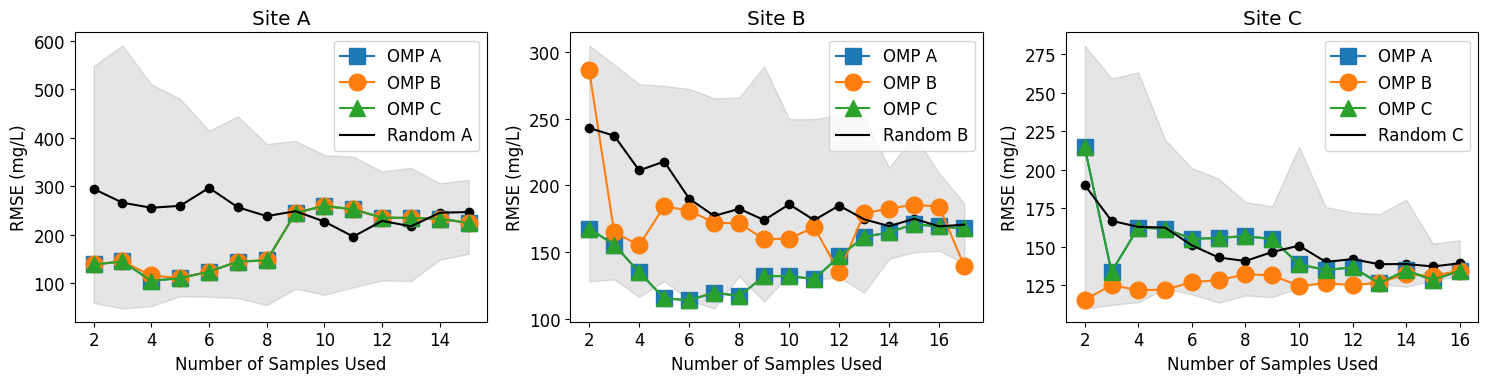

In [ ]:
# Plotting the curves with subplots for each site in optimal_dictionary and random_dictionary
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5* n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, site_id in enumerate(optimal_dictionary.keys()):
    if idx >= len(axes):
        break  # In case there are more than 3 sites

    ax = axes[idx]
    
    for i, model_id in enumerate(alpha_site_id):
        if model_id not in optimal_dictionary[site_id]:
            continue
        
        rmses = []
        sample_counts = []
        
        for n in sorted(optimal_dictionary[site_id][model_id].keys()):
            rmse = optimal_dictionary[site_id][model_id][n]['scores']['rmse']
            rmses.append(rmse)
            sample_counts.append(n)
        
        # Plot the curve
        ax.plot(sample_counts, rmses, linestyle='-', label=f'Static Transfer {model_id}', marker = markers[i], markersize = '12')
        print(f'Site {site_id}, Model {model_id} plotted')

    sample_size = len(optimal_dictionary[site_id]['x_sort'])
    base_rmse = optimal_dictionary[site_id]['baseline_rmse']
    # ax.plot(range(sample_size), np.ones(sample_size)*base_rmse, color = 'red', linewidth = 3, label='baseline RMSE')

for idx, site_id in enumerate(random_dictionary.keys()):
    if idx >= len(axes):
        break  # In case there are more than 3 sites

    ax = axes[idx]
    
    sample_sizes = []
    rmse_means = []
    rmse_mins = []
    rmse_maxs = []

    for n in random_dictionary[site_id].keys():
        
        if isinstance(n, np.int64):
            # print(n)
            sample_sizes.append(n)
            rmse_means.append(random_dictionary[site_id][n]['rmse_mean'])
            rmse_mins.append(random_dictionary[site_id][n]['rmse_best'][0])
            rmse_maxs.append(random_dictionary[site_id][n]['rmse_worst'][0])

    # Plot the curve with error bars
    # print(rmse_mins)
    # ax.errorbar(sample_sizes, rmse_means, yerr=[np.array(rmse_means) - np.array(rmse_mins), np.array(rmse_maxs) - np.array(rmse_means)],
                # fmt='-o', capsize=5, label=f'Random {site_id}', color = 'black')
    # Plot the shaded error bounds
    ax.plot(sample_sizes, rmse_means, color='black',label=f'Random {site_id}')
    ax.scatter(sample_sizes, rmse_means, color='black')
    ax.fill_between(sample_sizes, rmse_mins, rmse_maxs, color='black', alpha=0.1)
    
    ax.set_xlabel('Number of Samples Used')
    ax.set_ylabel('RMSE (mg/L)')
    ax.set_title(f'Site {site_id}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# Hide any unused subplots if optimal_dictionary has less than 3 sites
for i in range(len(optimal_dictionary), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.savefig('figures/RMSE_comparison.png', dpi=500)
plt.show()



# Active Learning

In [38]:
from pathlib import Path
import time
# import scipy.io
# import shutil

# ==== Config ====
PROJECT_ROOT = Path.cwd()
BASE_DIR = PROJECT_ROOT
DATASET_NAME = "GVR_USGS"  # or "GVR_LISST"
DATASET_DIR = BASE_DIR / DATASET_NAME
FLAGS_DIR = BASE_DIR / "flags"
SELECTION_HISTORY_DIR = DATASET_DIR / "selection_history"

# Create directories
FLAGS_DIR.mkdir(exist_ok=True, parents=True)
DATASET_DIR.mkdir(exist_ok=True, parents=True)
SELECTION_HISTORY_DIR.mkdir(exist_ok=True, parents=True)

# File flags
FLAG_PYTHON_READY = FLAGS_DIR / "ready_for_matlab.txt"
FLAG_MATLAB_READY = FLAGS_DIR / "ready_for_python.txt"

# Sample tracking
sample_limit_fraction = 0.8
num_select_each_round = 3
adaptive_learning = {}

def wait_for_file(path):
    print(f"⏳ Waiting for: {path}")
    while not path.exists():
        time.sleep(3)
    print(f"✅ Found: {path}")

def remove_file(path):
    if path.exists():
        path.unlink()

In [74]:
selection_history = {site_id: [] for site_id in alpha_site_id}
num_step = 5

def adaptive_sample_loop():
    for site_id in alpha_site_id:
        baseline_data = model_dictionary[site_id]['baseline']
        all_x = baseline_data['x_train']
        all_y = baseline_data['y_train']
        test_x = baseline_data['x_test']
        test_y = baseline_data['y_test']

        globalX = np.concatenate([all_x, test_x])
        globalY = np.concatenate([all_y, test_y])
        global_min_x, global_max_x = globalX.min(), globalX.max()
        global_min_y, global_max_y = globalY.min(), globalY.max()
        num_train = len(all_x)

        baseline_rmse = baseline_data['scores']['rmse']
        hp = baseline_data['hyperparams']
        baesline_const = hp.get('k1__constant_value', None)
        baseline_l = hp.get('k2__length_scale', None)

        print(f"\n🔁 Site {site_id}: max {num_train} samples to be used.")
        all_x_sort = all_x[np.argsort(all_x)]
        all_y_sort = all_y[np.argsort(all_x)]

        # Save xdata once for MATLAB
        scipy.io.savemat(DATASET_DIR / f"xdata_samp{site_id}.mat", {"xdata": all_x_sort.reshape(-1, 1)})

        adaptive_learning[site_id] = {
            'sample_limit': num_train,
            'x_sort': all_x_sort,
            'y_sort': all_y_sort,
            'baseline_rmse': baseline_rmse,
            'baseline_hyperparams': hp,
        }

        for model_id in alpha_site_id:
            adaptive_learning[site_id][model_id] = {}
            current_selected = []

            while len(current_selected) + num_step <= num_train:
                n_used = len(current_selected)
                print(f"🔢 {site_id}-{model_id} | Samples used: {n_used}")

                # Compute kernel matrix using current hyperparameters
                hp = adaptive_learning[site_id][model_id][n_used]['hyperparams'] if n_used > 0 else model_dictionary[model_id]['baseline']['hyperparams']
                # l, const_l = extract_kernel_hyperparams(ker)
                const_l = hp.get('k1__constant_value', None)
                l = hp.get('k2__length_scale', None)

                print(l, const_l)

                kern = np.zeros((num_train, num_train))
                for i, x in enumerate(all_x_sort):
                    for j, y in enumerate(all_x_sort):
                        kern[i, j] = const_rbf_kernel(x, y, l, const_l)

                cor_mat = cov_to_cor(kern)

                # Save correlation matrix and selected x indices
                corr_fname = f"corr_samp{site_id}{model_id}_{n_used}.mat"
                xdata_fname = f"xselect_samp{site_id}{model_id}_{n_used}.mat"
                scipy.io.savemat(DATASET_DIR / corr_fname, {"cor_mat": cor_mat})
                scipy.io.savemat(DATASET_DIR / xdata_fname, {"xdata": np.array(current_selected) + 1})

                print("📤 Wrote correlation and selection files. Now run MATLAB.")
                
                # === MANUAL PAUSE ===
                expected_matfile = DATASET_DIR / f"mat_xselect_samp{site_id}{model_id}_{n_used + num_step}.mat"
                while not expected_matfile.exists():
                    print(f"⏳ Waiting for {expected_matfile.name} ...")
                    time.sleep(1)

                mat_data = scipy.io.loadmat(expected_matfile)
                new_selected = (mat_data["A"][0] - 1).astype(int)
                current_selected += [i for i in new_selected if i not in current_selected]
                selection_history[site_id] = current_selected.copy()

                # Train GP
                x_train, y_train = all_x[current_selected], all_y[current_selected]
                SAC_pred, SSC_pred, std_p_pred, score, log_marg, GP_model, alpha, x_scale, y_scale = GP(
                    x_train, y_train, p,
                    SAC_test=test_x, SSC_test=test_y,
                    global_min_X=global_min_x, global_max_X=global_max_x,
                    global_min_Y=global_min_y, global_max_Y=global_max_y,
                )

                hp_new = extract_kernel_hyperparams(GP_model.kernel_)
                const_new = hp_new.get('k1__constant_value', None)
                l_new = hp_new.get('k2__length_scale', None)

                x_test_scaled = (test_x - global_min_x) / (global_max_x - global_min_x)
                ypred_scaled, std_pred_scaled = GP_model.predict(x_test_scaled.reshape(-1, 1), return_std=True)
                ypred = ypred_scaled * (global_max_y - global_min_y) + global_min_y
                std_pred = std_pred_scaled * (global_max_y - global_min_y)
                rmse = np.sqrt(np.mean((test_y - ypred) ** 2))
                r_score = GP_model.score(ypred.reshape(-1, 1), test_y.reshape(-1, 1))

                adaptive_learning[site_id][model_id][len(current_selected)] = {
                    'hyperparams': hp_new,
                    'cor_matrix': cor_mat,
                    'x_train': x_train,
                    'y_train': y_train,
                    'x_test': test_x,
                    'y_test': test_y,
                    'n_pred': ypred,
                    'p_pred': [SAC_pred, SSC_pred, std_p_pred],
                    'scores': {'rmse': rmse, 'std': std_pred},
                    'model': GP_model
                }

                np.save(SELECTION_HISTORY_DIR / f"{site_id}_selection.npy", np.array(current_selected))
                print(f"📈 Selected ({len(current_selected)}): {new_selected.tolist()}")

            print(f"✅ Done with model {model_id}")
        print(f"✅ Done with site {site_id}")

adaptive_sample_loop()



🔁 Site A: max 16 samples to be used.
🔢 A-A | Samples used: 0
0.8758747978304637 0.2859543424450591
📤 Wrote correlation and selection files. Now run MATLAB.
📈 Selected (5): [8, 2, 14, 0, 15]
🔢 A-A | Samples used: 5
1.0076860468298396 0.3356271601434049
📤 Wrote correlation and selection files. Now run MATLAB.


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 2.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression

📈 Selected (10): [8, 2, 14, 0, 15, 7, 3, 13, 1, 11]
🔢 A-A | Samples used: 10
0.8176757672265291 0.32443061018226244
📤 Wrote correlation and selection files. Now run MATLAB.
📈 Selected (15): [8, 2, 14, 0, 15, 7, 3, 13, 1, 11, 9, 4, 12, 6, 5]
✅ Done with model A
🔢 A-B | Samples used: 0
0.4445323695088585 0.3838169415388071
📤 Wrote correlation and selection files. Now run MATLAB.


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Use

📈 Selected (5): [9, 3, 14, 0, 12]
🔢 A-B | Samples used: 5
1.8415806939534214 0.07124905439611673
📤 Wrote correlation and selection files. Now run MATLAB.
📈 Selected (10): [9, 3, 14, 0, 12, 8, 2, 13, 1, 15]
🔢 A-B | Samples used: 10
0.7273761802485175 0.14132358943865428
📤 Wrote correlation and selection files. Now run MATLAB.


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/ke

📈 Selected (15): [9, 3, 14, 0, 12, 8, 2, 13, 1, 15, 7, 4, 11, 5, 10]
✅ Done with model B
🔢 A-C | Samples used: 0
0.9275657803910052 0.35279644019212697
📤 Wrote correlation and selection files. Now run MATLAB.
📈 Selected (5): [8, 2, 14, 0, 15]
🔢 A-C | Samples used: 5
1.0076860468298396 0.3356271601434049
📤 Wrote correlation and selection files. Now run MATLAB.


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__lengt

📈 Selected (10): [8, 2, 14, 0, 15, 7, 3, 13, 1, 11]
🔢 A-C | Samples used: 10
0.8176757672265291 0.32443061018226244
📤 Wrote correlation and selection files. Now run MATLAB.
📈 Selected (15): [8, 2, 14, 0, 15, 7, 3, 13, 1, 11, 9, 4, 12, 6, 5]
✅ Done with model C
✅ Done with site A

🔁 Site B: max 18 samples to be used.
🔢 B-A | Samples used: 0
0.8758747978304637 0.2859543424450591
📤 Wrote correlation and selection files. Now run MATLAB.


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Use

📈 Selected (5): [9, 3, 17, 1, 14]
🔢 B-A | Samples used: 5
0.3 0.08895535134769503
📤 Wrote correlation and selection files. Now run MATLAB.
📈 Selected (10): [9, 3, 17, 1, 14, 11, 5, 2, 13, 16]
🔢 B-A | Samples used: 10
0.6538481330123356 0.05000000000000001
📤 Wrote correlation and selection files. Now run MATLAB.


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

📈 Selected (15): [9, 3, 17, 1, 14, 11, 5, 2, 13, 16, 10, 4, 0, 15, 7]
✅ Done with model A
🔢 B-B | Samples used: 0
0.4445323695088585 0.3838169415388071
📤 Wrote correlation and selection files. Now run MATLAB.
📈 Selected (5): [11, 4, 1, 17, 16]
🔢 B-B | Samples used: 5
0.7980836203584921 0.05000000000000001
📤 Wrote correlation and selection files. Now run MATLAB.


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

📈 Selected (10): [11, 4, 1, 17, 16, 10, 3, 2, 15, 0]
🔢 B-B | Samples used: 10
0.818096430011428 0.05000000000000001
📤 Wrote correlation and selection files. Now run MATLAB.
📈 Selected (15): [11, 4, 1, 17, 16, 10, 3, 2, 15, 0, 9, 5, 14, 7, 12]
✅ Done with model B
🔢 B-C | Samples used: 0
0.9275657803910052 0.35279644019212697
📤 Wrote correlation and selection files. Now run MATLAB.


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

📈 Selected (5): [9, 2, 17, 5, 14]
🔢 B-C | Samples used: 5
0.5940362026142085 0.13509046512292022
📤 Wrote correlation and selection files. Now run MATLAB.
📈 Selected (10): [9, 2, 17, 5, 14, 10, 4, 1, 16, 13]
🔢 B-C | Samples used: 10
0.7459453736510971 0.05000000000000001
📤 Wrote correlation and selection files. Now run MATLAB.


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn

📈 Selected (15): [9, 2, 17, 5, 14, 10, 4, 1, 16, 13, 11, 3, 0, 15, 6]
✅ Done with model C
✅ Done with site B

🔁 Site C: max 17 samples to be used.
🔢 C-A | Samples used: 0
0.8758747978304637 0.2859543424450591
📤 Wrote correlation and selection files. Now run MATLAB.
📈 Selected (5): [9, 3, 16, 14, 5]
🔢 C-A | Samples used: 5
1.1527160803633905 0.698829492603517
📤 Wrote correlation and selection files. Now run MATLAB.


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  

📈 Selected (10): [9, 3, 16, 14, 5, 8, 2, 15, 4, 11]
🔢 C-A | Samples used: 10
0.8603713699658836 0.34417290816372276
📤 Wrote correlation and selection files. Now run MATLAB.
📈 Selected (15): [9, 3, 16, 14, 5, 8, 2, 15, 4, 11, 10, 6, 13, 1, 7]
✅ Done with model A
🔢 C-B | Samples used: 0
0.4445323695088585 0.3838169415388071
📤 Wrote correlation and selection files. Now run MATLAB.


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

📈 Selected (5): [10, 3, 14, 16, 5]
🔢 C-B | Samples used: 5
1.0099100355397772 0.6293235075168843
📤 Wrote correlation and selection files. Now run MATLAB.
📈 Selected (10): [10, 3, 14, 16, 5, 8, 2, 15, 4, 11]
🔢 C-B | Samples used: 10
0.8414778805649518 0.34307239996850514
📤 Wrote correlation and selection files. Now run MATLAB.


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

📈 Selected (15): [10, 3, 14, 16, 5, 8, 2, 15, 4, 11, 9, 6, 13, 1, 7]
✅ Done with model B
🔢 C-C | Samples used: 0
0.9275657803910052 0.35279644019212697
📤 Wrote correlation and selection files. Now run MATLAB.
📈 Selected (5): [8, 3, 16, 14, 5]
🔢 C-C | Samples used: 5
1.0603586934152438 0.6622616617354622
📤 Wrote correlation and selection files. Now run MATLAB.


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

📈 Selected (10): [8, 3, 16, 14, 5, 9, 2, 15, 4, 0]
🔢 C-C | Samples used: 10
0.8923612756093039 0.38652810501063706
📤 Wrote correlation and selection files. Now run MATLAB.
📈 Selected (15): [8, 3, 16, 14, 5, 9, 2, 15, 4, 0, 10, 6, 13, 1, 7]
✅ Done with model C
✅ Done with site C


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])


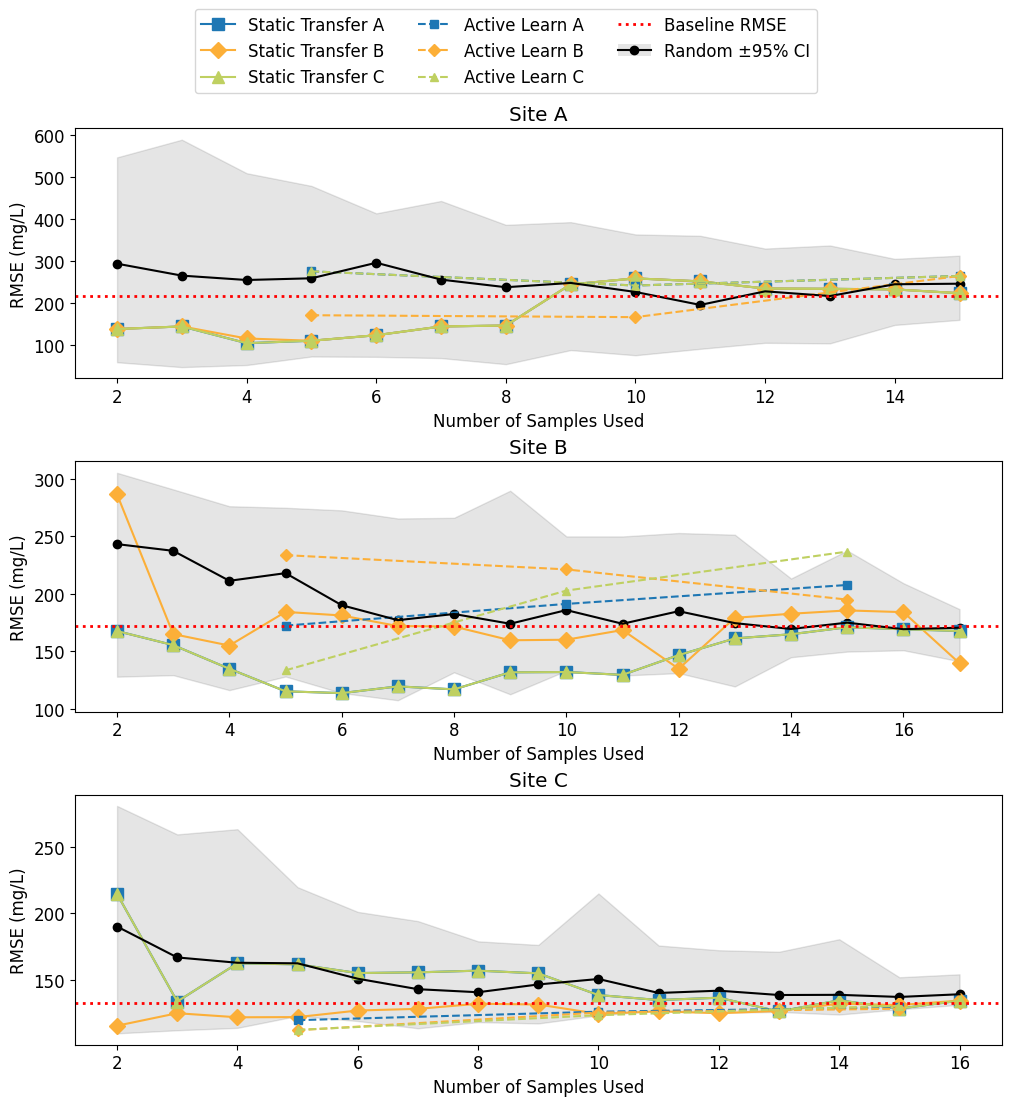

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerTuple

fig, axes = plt.subplots(7, 1, figsize=(10, 20), constrained_layout=True)

# To store legend handles/labels just once
legend_handles = []
legend_labels = []

for idx, site_id in enumerate(adaptive_learning.keys()):
    if idx >= len(axes):
        break

    ax = axes[idx]


    # === Plot OMP ===
    for i, model_id in enumerate(alpha_site_id):
        print(optimal_dictionary[site_id][model_id].keys())
        if model_id not in optimal_dictionary[site_id]:
            continue

        sample_counts = sorted(optimal_dictionary[site_id][model_id].keys())
        rmse_values = [
            optimal_dictionary[site_id][model_id][n]['scores']['rmse']
            for n in sample_counts
        ]

        line, = ax.plot(sample_counts, rmse_values, linestyle='-', color=colr_sc[i],
                label=f'OMP {model_id}', marker=markers[i+1], markersize=8)
        if idx == 0:  # Only collect handles from the first subplot
            legend_handles.append(line)
            legend_labels.append(f'Static Transfer {model_id}')

    # === Plot Adaptive Learning ===
    if site_id in adaptive_learning:
        for i, model_id in enumerate(alpha_site_id):
            if model_id not in adaptive_learning[site_id]:
                continue

            al_rmse = []
            al_counts = []

            for n in sorted(adaptive_learning[site_id][model_id].keys()):
                entry = adaptive_learning[site_id][model_id][n]
                if 'scores' in entry:
                    al_rmse.append(entry['scores']['rmse'])
                    al_counts.append(n)

            if al_rmse:
                line, = ax.plot(al_counts, al_rmse, linestyle='--', color=colr_sc[i],
                                label=f'Active Learn {model_id}', marker=markers[i+1], markersize=6)
                if idx == 0:  # Only collect handles from the first subplot
                    legend_handles.append(line)
                    legend_labels.append(f'Active Learn {model_id}')

# === Plot Random Sampling ===
for idx, site_id in enumerate(random_dictionary.keys()):
    if idx >= len(axes):
        break

    ax = axes[idx]

    sample_sizes = []
    rmse_means = []
    rmse_mins = []
    rmse_maxs = []

    for n in random_dictionary[site_id].keys():
        if isinstance(n, np.int64):
            sample_sizes.append(n)
            rmse_means.append(random_dictionary[site_id][n]['rmse_mean'])
            rmse_mins.append(random_dictionary[site_id][n]['rmse_best'][0])
            rmse_maxs.append(random_dictionary[site_id][n]['rmse_worst'][0])

    line = ax.plot(sample_sizes, rmse_means, color='black', label=f'Random {site_id}')[0]
    ax.scatter(sample_sizes, rmse_means, color='black',label=f'Random {site_id}' )
    ax.fill_between(sample_sizes, rmse_mins, rmse_maxs, color='black', alpha=0.1, label="Random ±95% CI")


    if idx == 0:
        # Create custom legend entry: line with marker + shaded patch
        legend_line = Line2D([], [], color='black', linestyle='-', marker='o', markersize=6)
        legend_patch = Patch(facecolor='black', edgecolor='none', alpha=0.1)
        legend_handles.append((legend_line, legend_patch))
        legend_labels.append("Random ±95% CI")

    ax.set_xlabel('Number of Samples Used')
    ax.set_ylabel('RMSE (mg/L)')
    ax.set_title(f'Site {site_id}')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Hide unused subplots
for i in range(len(adaptive_learning), len(axes)):
    fig.delaxes(axes[i])

# Add shared legend above all plots
fig.legend(
    legend_handles,
    legend_labels,
    loc='upper center',
    ncol=3,  # or adjust to your preferred number of columns
    fontsize='medium',
    bbox_to_anchor=(0.5, 1.05)  # adjust vertical spacing if needed
)

# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
# plt.show()


# Time Series Prediction

0
opt_y: 6, train_ssc: 6, train_datetimes: 6
1
opt_y: 6, train_ssc: 6, train_datetimes: 6
2
opt_y: 6, train_ssc: 6, train_datetimes: 6
0
opt_y: 6, train_ssc: 6, train_datetimes: 6
1
opt_y: 6, train_ssc: 6, train_datetimes: 6
2
opt_y: 6, train_ssc: 6, train_datetimes: 6
0
opt_y: 6, train_ssc: 6, train_datetimes: 6
1
opt_y: 6, train_ssc: 6, train_datetimes: 6
2
opt_y: 6, train_ssc: 6, train_datetimes: 6


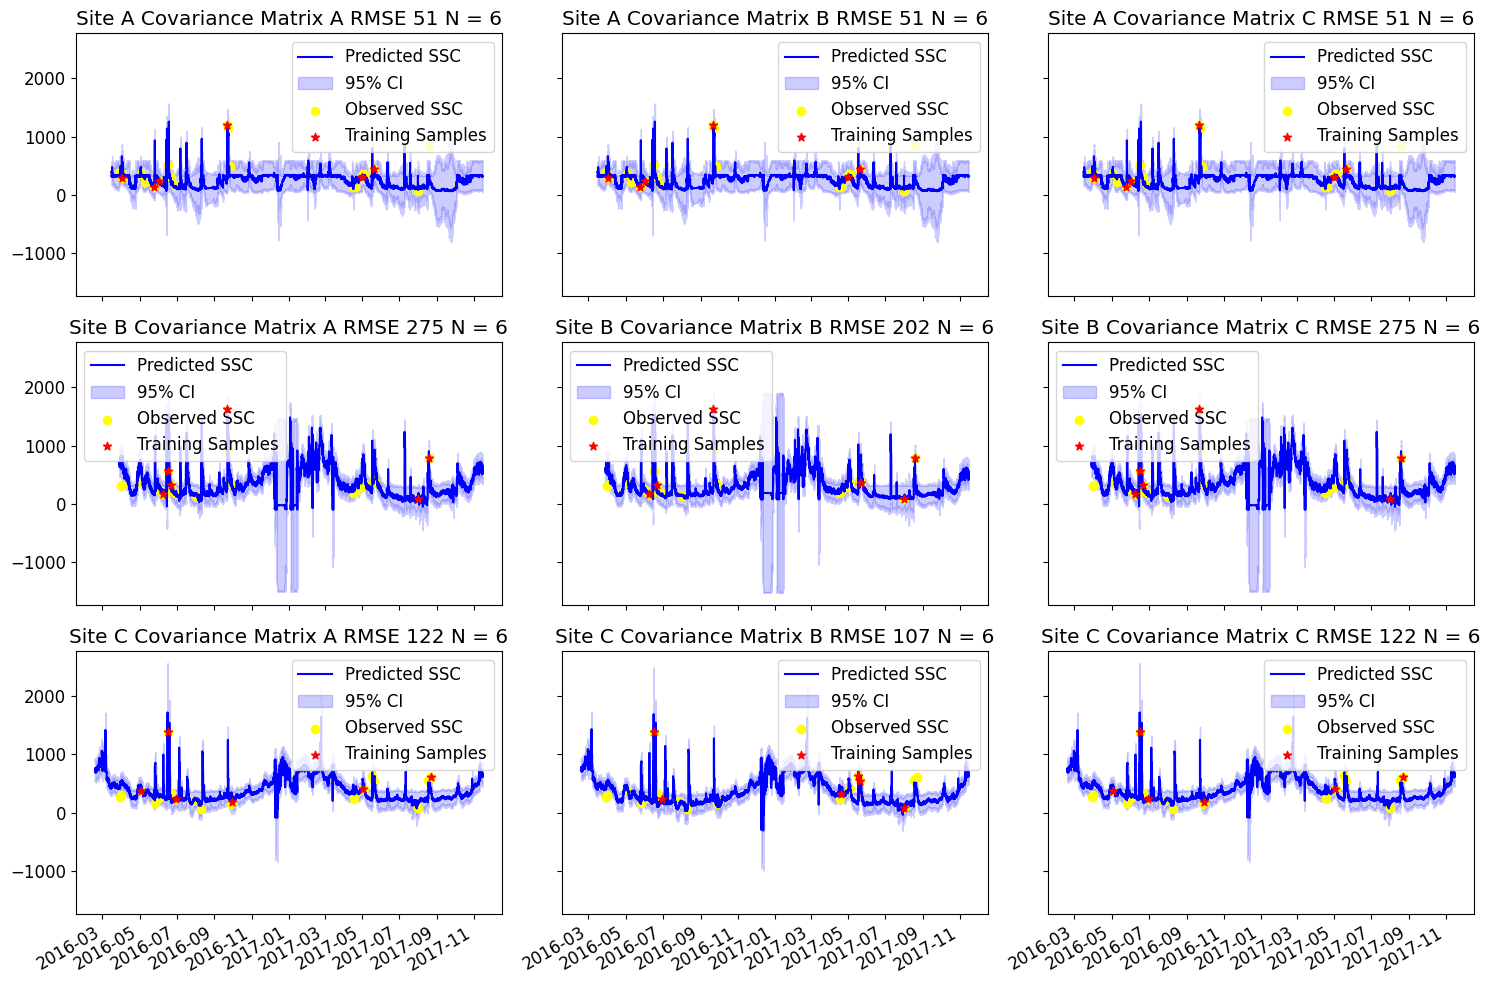

In [ ]:
# Set up the 3x3 grid of plots
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()
# number samples to use for optimal training
n = 6
# Predict SSC using SAC data from `site_data[ADVM]`
plot_index = 0
for site_id in alpha_site_id:
    baseline_data = model_dictionary[site_id]['baseline']
    all_x = baseline_data['x_train']
    all_y = baseline_data['y_train']
    # What to test models on
    test_x = baseline_data['x_test']
    test_y = baseline_data['y_test']

    globalX = np.concatenate([all_x, test_x])
    globalY = np.concatenate([all_y, test_y])
    global_min_x = globalX.min()
    global_max_x = globalX.max()
    global_min_y = globalY.min()
    global_max_y = globalY.max()    
    y_range = global_max_y - global_min_y

    for i, cov_id in enumerate(alpha_site_id):
        # site_id = USGS_site_id[id]
        site_data = data_dictionary[site_id]
        advm_data = site_data['ADVM']
        sac_data = advm_data['SAC'].to_numpy()
        datetime_num_data = advm_data['DateTime']  # Should be pandas datetime or datetime64
        datetime_data = serialTimeToDatetime(datetime_num_data)


        # Use the GP model to predict SSC. This is the GP generated using covariance matrix of a site to select samples of another
        
        GP_model = optimal_dictionary[site_id][cov_id][n]['model']
        rmse_opt = optimal_dictionary[site_id][cov_id][n]['scores']['rmse']

        sac_data_scaled = (sac_data - global_min_x) / (global_max_x - global_min_x)  # Scale SAC data
        ssc_pred_scaled, ssc_std_scaled = GP_model.predict(sac_data_scaled.reshape(-1, 1), return_std=True)
        ssc_pred = ssc_pred_scaled * y_range + global_min_y  # Scale the predictions back to original range
        ssc_std = ssc_std_scaled * y_range  # Scale the standard deviation back to original range
        print(i)
        # Plot the predictions
        ax = axes[plot_index]
        ax.plot(datetime_data, ssc_pred, color='blue', label='Predicted SSC')
        ax.fill_between(datetime_data, ssc_pred - 1.96 * ssc_std, ssc_pred + 1.96 * ssc_std, color='blue', alpha=0.2, label='95% CI')
        
        # Match the sizes of x and y for observed data
        valid_indices = ~np.isnan(site_data['Samples']['SSC'])
        observed_num_dates = site_data['Samples']['DateTime'][valid_indices]
        observed_dates = serialTimeToDatetime(observed_num_dates)
        observed_ssc = site_data['Samples']['SSC'][valid_indices]
        observed_opt_x = site_data['Samples']['SAC'][valid_indices]
        ax.scatter(observed_dates, observed_ssc, color='yellow', label='Observed SSC')
       
        opt_y = optimal_dictionary[site_id][cov_id][n]['y_train']
        opt_x = optimal_dictionary[site_id][cov_id][n]['x_train']


        # Convert all to numpy arrays
        observed_opt_x = np.array(observed_opt_x)
        observed_ssc = np.array(observed_ssc)
        opt_x = np.array(opt_x)
        opt_y = np.array(opt_y)

        # Stack the full and training pairs
        all_pairs = np.stack((observed_opt_x, observed_ssc), axis=1)
        opt_pairs = np.stack((opt_x, opt_y), axis=1)

        # Find matching rows, scan for both x and y corresponding values to match to avoid instances where there are multiple observed times of y
        matches = np.any(np.all(all_pairs[:, None] == opt_pairs[None, :], axis=2), axis=1)

        # Get the matching subset
        train_sac = observed_opt_x[matches]   
        train_ssc = observed_ssc[matches]     

        train_datetimes = observed_dates[matches]

        

    #    # Create a boolean mask where observed_ssc values are in opt_y
    #     mask = np.isin(observed_ssc, opt_y)

    #     # Apply mask to observed_ssc and observed_dates to get aligned subsets
    #     train_ssc = observed_ssc[mask]
    #     train_datetimes = np.array(observed_dates)[mask]
        print(f'opt_y: {len(opt_y)}, train_ssc: {len(train_ssc)}, train_datetimes: {len(train_datetimes)}')

        # Plot
        ax.scatter(train_datetimes, train_ssc, color='red', marker ='*', label='Training Samples', zorder=10)
        
        ax.set_title(f'Site {site_id} Covariance Matrix {cov_id} RMSE {rmse_opt:.0f} N = {n}')
        ax.legend()

        plot_index += 1

fig.tight_layout()
fig.autofmt_xdate()
fig.tight_layout()
plt.show()


opt_y: 6, train_ssc: 6, train_datetimes: 6
opt_y: 6, train_ssc: 6, train_datetimes: 6
opt_y: 6, train_ssc: 6, train_datetimes: 6


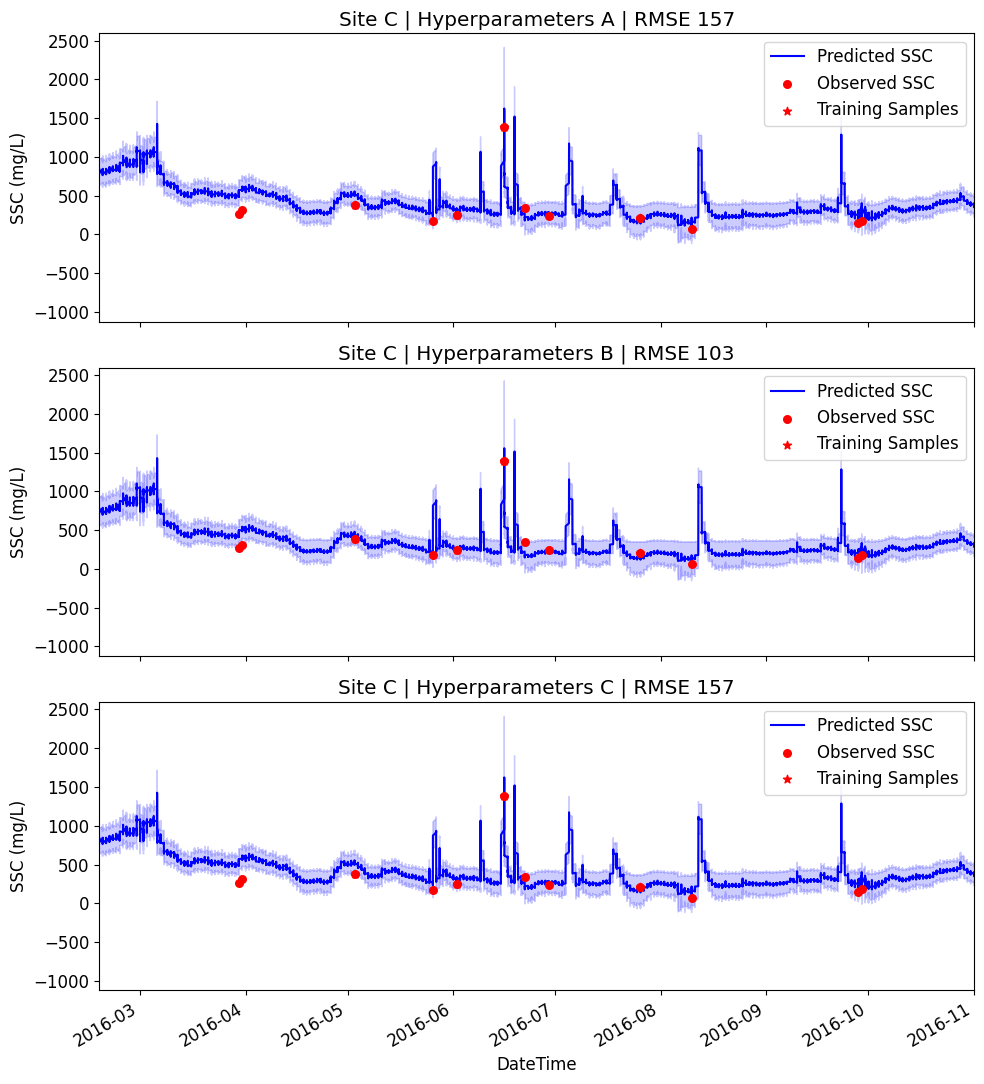

In [ ]:
# Only one column for Site C with different covariance matrices
fig, axes = plt.subplots(3, 1, figsize=(10, 11), sharex=True, sharey=True)
if not isinstance(axes, np.ndarray):  # In case there's only one subplot
    axes = [axes]

site_id = 'C'  # Fix to only Site C
n = 6  # Number of samples for optimal training

baseline_data = model_dictionary[site_id]['baseline']
all_x = baseline_data['x_train']
all_y = baseline_data['y_train']
# What to test models on
test_x = baseline_data['x_test']
test_y = baseline_data['y_test']

globalX = np.concatenate([all_x, test_x])
globalY = np.concatenate([all_y, test_y])
global_min_x = globalX.min()
global_max_x = globalX.max()
global_min_y = globalY.min()
global_max_y = globalY.max()    
y_range = global_max_y - global_min_y

# Loop over different kernel covariance matrices (cov_id = A, B, C, etc.)
for i, cov_id in enumerate(alpha_site_id):
    site_data = data_dictionary[site_id]
    advm_data = site_data['ADVM']
    sac_data = advm_data['SAC'].to_numpy()
    datetime_num_data = advm_data['DateTime']  # Should be pandas datetime or datetime64
    datetime_data = serialTimeToDatetime(datetime_num_data)
    
    # GP model trained with samples from cov_id applied to Site C
    GP_model = optimal_dictionary[site_id][cov_id][n]['model']
    rmse_opt = optimal_dictionary[site_id][cov_id][n]['scores']['rmse']
    sac_data_scaled = (sac_data - global_min_x) / (global_max_x - global_min_x)  # Scale SAC data
    ssc_pred_scaled, ssc_std_scaled = GP_model.predict(sac_data_scaled.reshape(-1, 1), return_std=True)
    ssc_pred = ssc_pred_scaled * y_range + global_min_y  # Scale the predictions back to original range
    ssc_std = ssc_std_scaled * y_range  # Scale the standard deviation back to original range

    # ssc_pred, ssc_std = GP_model.predict(sac_data.reshape(-1, 1), return_std=True)

    # Plotting
    ax = axes[i]
    ax.plot(datetime_data, ssc_pred, color='blue', label='Predicted SSC')
    ax.fill_between(datetime_data, ssc_pred - 1.96 * ssc_std, ssc_pred + 1.96 * ssc_std, color='blue', alpha=0.2)

    # Observed data
    valid_indices = ~np.isnan(site_data['Samples']['SSC'])
    observed_num_dates = site_data['Samples']['DateTime'][valid_indices]
    observed_dates = serialTimeToDatetime(observed_num_dates)
    observed_opt_x = site_data['Samples']['SAC'][valid_indices]
    observed_ssc = site_data['Samples']['SSC'][valid_indices]
    ax.scatter(observed_dates, observed_ssc, color='red', label='Observed SSC', s=30, zorder=10)

    opt_y = optimal_dictionary[site_id][cov_id][n]['y_train']
    opt_x = optimal_dictionary[site_id][cov_id][n]['x_train']


    # Convert all to numpy arrays
    observed_opt_x = np.array(observed_opt_x)
    observed_ssc = np.array(observed_ssc)
    opt_x = np.array(opt_x)
    opt_y = np.array(opt_y)

    # Stack the full and training pairs
    all_pairs = np.stack((observed_opt_x, observed_ssc), axis=1)
    opt_pairs = np.stack((opt_x, opt_y), axis=1)

    # Find matching rows, scan for both x and y corresponding values to match to avoid instances where there are multiple observed times of y
    matches = np.any(np.all(all_pairs[:, None] == opt_pairs[None, :], axis=2), axis=1)

    # Get the matching subset
 
    train_ssc = observed_ssc[matches]     

    train_datetimes = observed_dates[matches]

    

#    # Create a boolean mask where observed_ssc values are in opt_y
#     mask = np.isin(observed_ssc, opt_y)

#     # Apply mask to observed_ssc and observed_dates to get aligned subsets
#     train_ssc = observed_ssc[mask]
#     train_datetimes = np.array(observed_dates)[mask]
    print(f'opt_y: {len(opt_y)}, train_ssc: {len(train_ssc)}, train_datetimes: {len(train_datetimes)}')

    # Plot
    ax.scatter(train_datetimes, train_ssc, color='red', marker ='*', label='Training Samples', zorder=10)
    



    ax.set_title(f'Site {site_id} | Hyperparameters {cov_id} | RMSE {rmse_opt:.0f}')
    ax.legend()
    ax.set_xlabel("DateTime")
    
    ax.set_ylabel("SSC (mg/L)")


# Set x-axis limit to the November 2016
date_cutoff = datetime(2016, 11, 1)
ax.set_xlim([datetime_data[0], date_cutoff])
fig.autofmt_xdate()
fig.tight_layout()
# plt.savefig('figures/Site3_SSC.png', dpi=500)
plt.show()


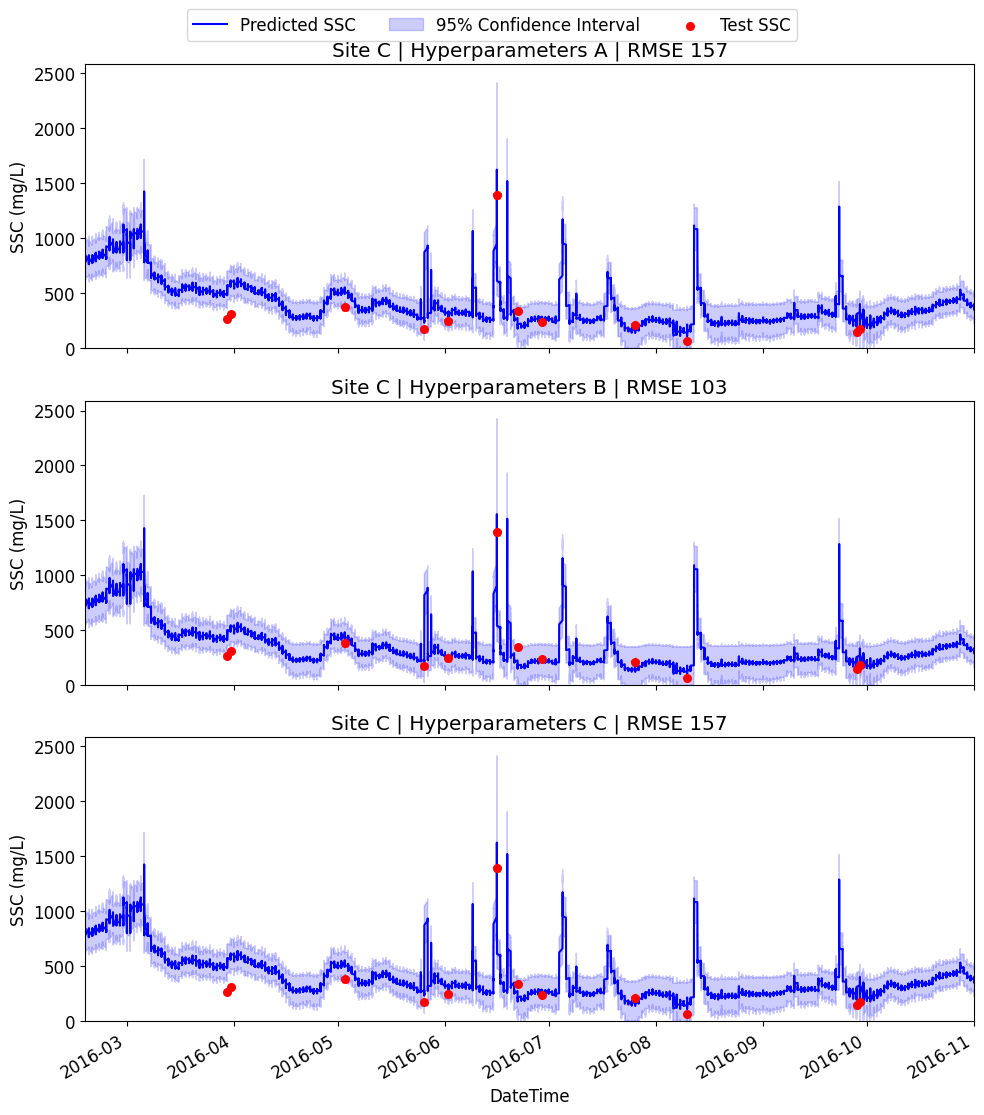

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerTuple

fig, axes = plt.subplots(3, 1, figsize=(10, 11), sharex=True, sharey=False)
if not isinstance(axes, np.ndarray):  # In case there's only one subplot
    axes = [axes]

site_id = 'C'  # Fix to only Site C
n = 6  # Number of samples for optimal training

baseline_data = model_dictionary[site_id]['baseline']
all_x = baseline_data['x_train']
all_y = baseline_data['y_train']
# What to test models on
test_x = baseline_data['x_test']
test_y = baseline_data['y_test']

globalX = np.concatenate([all_x, test_x])
globalY = np.concatenate([all_y, test_y])
global_min_x = globalX.min()
global_max_x = globalX.max()
global_min_y = globalY.min()
global_max_y = globalY.max()    
y_range = global_max_y - global_min_y

legend_handles = []
legend_labels = []

for i, cov_id in enumerate(alpha_site_id):
    site_data = data_dictionary[site_id]
    advm_data = site_data['ADVM']
    sac_data = advm_data['SAC'].to_numpy()
    datetime_num_data = advm_data['DateTime']  # Should be pandas datetime or datetime64
    datetime_data = serialTimeToDatetime(datetime_num_data)

    # GP model trained with samples from cov_id applied to Site C
    GP_model = optimal_dictionary[site_id][cov_id][n]['model']
    rmse_opt = optimal_dictionary[site_id][cov_id][n]['scores']['rmse']
    sac_data_scaled = (sac_data - global_min_x) / (global_max_x - global_min_x)  # Scale SAC data
    ssc_pred_scaled, ssc_std_scaled = GP_model.predict(sac_data_scaled.reshape(-1, 1), return_std=True)
    ssc_pred = ssc_pred_scaled * y_range + global_min_y  # Scale the predictions back to original range
    ssc_std = ssc_std_scaled * y_range  # Scale the standard deviation back to original range

    ax = axes[i]
    # Plot predicted SSC and 95% CI fill
    line_pred, = ax.plot(datetime_data, ssc_pred, color='blue', label='Predicted SSC')
    fill_pred = ax.fill_between(datetime_data, ssc_pred - 1.96 * ssc_std, ssc_pred + 1.96 * ssc_std,
                               color='blue', alpha=0.2, label='95% Confidence Interval')

    # Collect legend handles once
    if i == 0:
        legend_handles.append(line_pred)
        legend_handles.append(fill_pred)
        legend_labels.append('Predicted SSC')
        legend_labels.append('95% Confidence Interval')

    # Observed data points
    valid_indices = ~np.isnan(site_data['Samples']['SSC'])
    observed_num_dates = site_data['Samples']['DateTime'][valid_indices]
    observed_dates = serialTimeToDatetime(observed_num_dates)
    observed_opt_x = site_data['Samples']['SAC'][valid_indices]
    observed_ssc = site_data['Samples']['SSC'][valid_indices]
    scatter_obs = ax.scatter(observed_dates, observed_ssc, color='red', label='Observed SSC', s=30, zorder=10)
    
    if i == 0:
        legend_handles.append(scatter_obs)
        legend_labels.append('Test SSC')

    # Training samples highlighting
    opt_y = np.array(optimal_dictionary[site_id][cov_id][n]['y_train'])
    opt_x = np.array(optimal_dictionary[site_id][cov_id][n]['x_train'])

    all_pairs = np.stack((np.array(observed_opt_x), np.array(observed_ssc)), axis=1)
    opt_pairs = np.stack((opt_x, opt_y), axis=1)

    matches = np.any(np.all(all_pairs[:, None] == opt_pairs[None, :], axis=2), axis=1)
    train_ssc = np.array(observed_ssc)[matches]
    train_datetimes = np.array(observed_dates)[matches]

    scatter_train = ax.scatter(train_datetimes, train_ssc, color='red', marker='*', label='Training Samples', zorder=10)
    
    if i == 0:
        legend_handles.append(scatter_train)
        # legend_labels.append('Training Samples')

    ax.set_title(f'Site {site_id} | Hyperparameters {cov_id} | RMSE {rmse_opt:.0f}')
    ax.set_xlabel("DateTime")
    ax.set_ylabel("SSC (mg/L)")

    # Set y-axis limits so it does not go below zero, keep upper bound as auto
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(bottom=0, top=ymax)

# Set x-axis limit to November 1, 2016 (on the last axis)
date_cutoff = datetime(2016, 11, 1)
axes[-1].set_xlim([datetime_data[0], date_cutoff])

fig.autofmt_xdate()
fig.tight_layout()

# Add one shared legend above all subplots
fig.legend(legend_handles, legend_labels, loc='upper center', ncol=4, fontsize='medium', bbox_to_anchor=(0.5, 1.02))

plt.show()
